In [1]:
import os 
import matplotlib
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation,PillowWriter
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import random
import cutde.fullspace as FS
import plotly
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import svd, lstsq
from scipy.sparse.linalg import svds
from scipy.integrate import cumulative_trapezoid
from scipy.signal import detrend
from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator as rgi
from operator import itemgetter
import matplotlib.dates as mdates
from datetime import datetime
from more_itertools import sliced
from numpy.linalg import norm
from numpy.linalg import solve
# import scipy.interpolate as sp
# import cmasher as cmr
import pickle
# from dts_funcs import * 
import gc
import collections

### Function to extract slices from array-like objects

In [2]:
def xslice(x, slices):
    """Extract slices from array-like
    Args:
        x: array-like
        slices: slice or tuple of slice objects
    """
    if isinstance(slices, tuple):
        if isinstance(x, np.ndarray):
            return np.concatenate([x[_slice] for _slice in slices])
        else:
            return sum((x[s] if isinstance(s, slice) else [x[s]] for s in slices), [])        
    elif isinstance(slices, slice):
        return x[slices]
    else:
        return [x[slices]]

### Read in the low-pass filtered DAS data

In [3]:
# def stack_DAS(das_dat):
#     n = das_dat.shape[1]
#     m = n // 2
#     a1 = das_dat[:,1:m+1]
#     a2 = np.fliplr(das_dat[:,m+1:])
#     return  np.divide(np.add(a1,a2),2)

df_rawPDT = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellPDT/maystim22_26_combined_full').to_numpy()
df_rawPDB = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellPDB/maystim22_26_combined_full').to_numpy()
df_rawPST = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellPST/maystim22_26_combined_full').to_numpy()
df_rawPSB = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellPSB/maystim22_26_combined_full').to_numpy()
# df_rawOT = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellOT/maystim22_26_combined_full').to_numpy()
df_rawOB = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellOB/maystim22_26_combined_full').to_numpy()

# df_rawPDT = stack_DAS(df_rawPDT)
# df_rawPDB = stack_DAS(df_rawPDB)
# df_rawPST = stack_DAS(df_rawPST)
# df_rawPSB = stack_DAS(df_rawPSB)
# df_rawOT = stack_DAS(df_rawOT)
# df_rawOB = stack_DAS(df_rawOB)

df_rawPDT = detrend(df_rawPDT,axis=0,type='constant')
df_rawPDB = detrend(df_rawPDB,axis=0,type='constant')
df_rawPST = detrend(df_rawPST,axis=0,type='constant')
df_rawPSB = detrend(df_rawPSB,axis=0,type='constant')
# df_rawOT = detrend(df_rawOT,axis=0,type='constant')
df_rawOB = detrend(df_rawOB,axis=0,type='constant')
df_rawPDT = detrend(df_rawPDT,axis=0,type='linear')
df_rawPDB = detrend(df_rawPDB,axis=0,type='linear')
df_rawPST = detrend(df_rawPST,axis=0,type='linear')
df_rawPSB = detrend(df_rawPSB,axis=0,type='linear')
# df_rawOT = detrend(df_rawOT,axis=0,type='linear')
df_rawOB = detrend(df_rawOB,axis=0,type='linear')

# wn     = ['PDT','PDB','PST','PSB','OT','OB']
wn     = ['PDT','PDB','PST','PSB','OB']
nfile_list = sorted(os.walk('/data1/parker/EGS_iDAS'))
nfile_list = nfile_list[1:]
nfile_list = [group[2] for group in nfile_list]
nfile_list = [item for sublist in nfile_list for item in sublist]
fd = [name.split("_") for name in nfile_list]
fl = [fd[file][2].split(".") for file in range(len(fd))]
fl = [el[0] for el in fl]
DASdates = [datetime.strptime(d,'%y%m%d%H%M%S') for d in sorted(fl)]
# these are files that get skipped during the low pass filtering process and so the dates need to be removed 
ind2rem = [0, 90, 91, 257, 258, 1571, 1572, 3082, 3083, 5085, 5086, 5599, 5600, 5961, 5962, 7623, 7624, 8841, 8842, 9562]
# remove in reverse so that the indices remain in the correct order for removal
for index in sorted(ind2rem,reverse=True):
    del DASdates[index]

DASdates3 = DASdates[5588:7607]
DASdates45 = xslice(DASdates,np.s_[7608:8237,8262:])
stimbeg = [0, 2448, 5737, 7749, 8405]
stimfin = [29, 2578, 5813, 7807, 8469]
stimbegLines = itemgetter(*stimbeg)(DASdates)
stimfinLines = itemgetter(*stimfin)(DASdates)
dasdnums = mdates.date2num(DASdates)


In [4]:
# scaling equation provided by Silixa (tdmsvalues/2048)*116*(fs/gaugeLength)
# set up matrices to scale the data by their different Fs values
fsvecPDT = np.ones_like(df_rawPDT)
fsvecPDB = np.ones_like(df_rawPDB)
# fsvecOT = np.ones_like(df_rawOT)
fsvecOB = np.ones_like(df_rawOB)
fsvecPST = np.ones_like(df_rawPST)
fsvecPSB = np.ones_like(df_rawPSB)
# These are the indices where the sampling rate changes between 1kHz and 10kHz
lst = [0,88,10000,89,1565,1000,1566,5075,10000,5076,5587,1000,5588,7607,10000,7608,9543,1000]
lst = np.array(list(sliced((lst),3))).reshape(6,3)
# fill the matrices with the correct sampling freqs
for i in range(len(lst)):
    fsvecPDT[lst[i][0]:lst[i][1]+1,:] = fsvecPDT[lst[i][0]:lst[i][1]+1,:]*lst[i][2]
    fsvecPDB[lst[i][0]:lst[i][1]+1,:] = fsvecPDB[lst[i][0]:lst[i][1]+1,:]*lst[i][2]
    # fsvecOT[lst[i][0]:lst[i][1]+1,:] = fsvecOT[lst[i][0]:lst[i][1]+1,:]*lst[i][2]
    fsvecOB[lst[i][0]:lst[i][1]+1,:] = fsvecOB[lst[i][0]:lst[i][1]+1,:]*lst[i][2]
    fsvecPST[lst[i][0]:lst[i][1]+1,:] = fsvecPST[lst[i][0]:lst[i][1]+1,:]*lst[i][2]
    fsvecPSB[lst[i][0]:lst[i][1]+1,:] = fsvecPSB[lst[i][0]:lst[i][1]+1,:]*lst[i][2]
# divide by gauge length
fsvecPDT /= 10.
fsvecPDB /= 10.
# fsvecOT /= 10.
fsvecOB /= 10.
fsvecPST /= 10.
fsvecPSB /= 10.
# multiply the data by the scaling matrices and then scale by the Silixa scaling value
scaledPDT = np.multiply(fsvecPDT,df_rawPDT)
scaledPDT = np.multiply(scaledPDT,(116/2048))
scaledPDB = np.multiply(fsvecPDB,df_rawPDB)
scaledPDB = np.multiply(scaledPDB,(116/2048))
# scaledOT = np.multiply(fsvecOT,df_rawOT)
# scaledOT = np.multiply(scaledOT,(116/2048))
scaledOB = np.multiply(fsvecOB,df_rawOB)
scaledOB = np.multiply(scaledOB,(116/2048))
scaledPST = np.multiply(fsvecPST,df_rawPST)
scaledPST = np.multiply(scaledPST,(116/2048))
scaledPSB = np.multiply(fsvecPSB,df_rawPSB)
scaledPSB = np.multiply(scaledPSB,(116/2048))

# Copy strain rates
df_fullPDT = scaledPDT[:,:df_rawPDT.shape[1]//2].copy()
df_fullPDB = scaledPDB[:,:df_rawPDB.shape[1]//2].copy()
df_fullPST = scaledPST[:,:df_rawPST.shape[1]//2].copy()
df_fullPSB = scaledPSB[:,:df_rawPSB.shape[1]//2].copy()
# df_fullOT = scaledOT[:,:df_rawOT.shape[1]//2].copy()
df_fullOB = scaledOB[:,12:df_rawOB.shape[1]//2].copy()

# Integrate strain rates to strain for all stims
df_strainPDT = detrend(cumulative_trapezoid(df_fullPDT,axis=0,initial=0),type='linear')
df_strainPDB = detrend(cumulative_trapezoid(df_fullPDB,axis=0,initial=0),type='linear')
df_strainPST = detrend(cumulative_trapezoid(df_fullPST,axis=0,initial=0),type='linear')
df_strainPSB = detrend(cumulative_trapezoid(df_fullPSB,axis=0,initial=0),type='linear')
# df_strainOT = detrend(cumulative_trapezoid(df_fullOT,axis=0,initial=0),type='linear')
df_strainOB = detrend(cumulative_trapezoid(df_fullOB,axis=0,initial=0),type='linear')
df_strainPDT = detrend(cumulative_trapezoid(df_fullPDT,axis=0,initial=0),type='constant')
df_strainPDB = detrend(cumulative_trapezoid(df_fullPDB,axis=0,initial=0),type='constant')
df_strainPST = detrend(cumulative_trapezoid(df_fullPST,axis=0,initial=0),type='constant')
df_strainPSB = detrend(cumulative_trapezoid(df_fullPSB,axis=0,initial=0),type='constant')
# df_strainOT = detrend(cumulative_trapezoid(df_fullOT,axis=0,initial=0),type='constant')
df_strainOB = detrend(cumulative_trapezoid(df_fullOB,axis=0,initial=0),type='constant')
# Integrate strain rates to strain for stims 4 and 5
# cut out noise 
df_strainPDT45 = xslice(df_strainPDT,np.s_[7608:8237,8262:])
df_strainPDB45 = xslice(df_strainPDB,np.s_[7608:8237,8262:])
df_strainPST45 = xslice(df_strainPST,np.s_[7608:8237,8262:])
df_strainPSB45 = xslice(df_strainPSB,np.s_[7608:8237,8262:])
# df_strainOT45 = xslice(df_strainOT,np.s_[7608:8237,8262:])
df_strainOB45 = xslice(df_strainOB,np.s_[7608:8237,8262:])
# create channel spacing vectors
chansOB=np.linspace(0,df_strainOB.shape[1] - 1,df_fullOB.shape[1]).astype(int)
# chansOT=np.linspace(0,df_strainOT.shape[1] - 1,df_fullOT.shape[1]).astype(int)
chansPSB=np.linspace(0,df_strainPSB.shape[1] - 1,df_fullPSB.shape[1]).astype(int)
chansPST=np.linspace(0,df_strainPST.shape[1] - 1,df_fullPST.shape[1]).astype(int)
chansPDB=np.linspace(0,df_strainPDB.shape[1] - 1,df_fullPDB.shape[1]).astype(int)
chansPDT=np.linspace(0,df_strainPDT.shape[1] - 1,df_fullPDT.shape[1]).astype(int)

# all_strain_dat = [df_fullOB,df_fullOT,df_fullPDB,df_fullPDT,df_fullPSB,df_fullPST]

### Read in borehole geometry files

In [5]:

geomcols=np.arange(8)
wellcols=np.arange(12)
CASSMGeom=pd.read_excel('/home/spri902/Collab_metadata/SigmaV_Channel_Monitoring_Rev_1.0_PetrovMod.xlsx',\
                        sheet_name='Geode',header=0,usecols=geomcols)
CASSMsrc=pd.read_excel('/home/spri902/Collab_metadata/SigmaV_Channel_Monitoring_Rev_1.0_PetrovMod.xlsx',\
                        sheet_name='CASSM_Channels',header=0,usecols=geomcols)
CASSMsrc.columns = [c.replace(' ','_') for c in CASSMsrc.columns]
wellcols=np.arange(12)
WellGeom=pd.read_excel('/home/spri902/Collab_metadata/Well_Points.xlsx',header=0,usecols=wellcols)
WellGeom.columns = WellGeom.columns.str.replace(' ','')
# convert from feet to meters
WellGeom.x = WellGeom.x/3.28084
WellGeom.y = WellGeom.y/3.28084
WellGeom.z = WellGeom.z/3.28084
# pull out the monitoring wells
mwells=[]
wellList = ['E1-OB','E1-OT','E1-PDT','E1-PDB','E1-PST','E1-PSB']
for i in wellList:
    tmpwell = WellGeom[WellGeom["HoleID"]== i]
    tmpwell = tmpwell.iloc[:,0:6]
    mwells.append(tmpwell)
mwells = pd.concat(mwells)
# pull out the injector and production wells
swells=[]
wellList = ['E1-I','E1-P']
for i in wellList:
    tmpwell = WellGeom[WellGeom["HoleID"]== i]
    tmpwell = tmpwell.iloc[:,0:6]
    swells.append(tmpwell)
swells = pd.concat(swells)

# take every 10th point (1 meter spacing along well)
PDBpnts = mwells[mwells['HoleID'] == 'E1-PDB' ].iloc[0::10,:]
PDBpnts = PDBpnts[1:df_fullPDB.shape[1]]
PDTpnts = mwells[mwells['HoleID'] == 'E1-PDT' ].iloc[0::10,:]
PDTpnts = PDTpnts[1:df_fullPDT.shape[1]]

PSBpnts = mwells[mwells['HoleID'] == 'E1-PSB' ].iloc[0::10,:]
PSBpnts = PSBpnts[1:df_fullPSB.shape[1]]
PSTpnts = mwells[mwells['HoleID'] == 'E1-PST' ].iloc[0::10,:]
PSTpnts = PSTpnts[1:df_fullPST.shape[1]]

OBpnts = mwells[mwells['HoleID'] == 'E1-OB' ].iloc[0::10,:]
OBpnts = OBpnts[1:df_fullOB.shape[1]]
# OTpnts = mwells[mwells['HoleID'] == 'E1-OT' ].iloc[0::10,:]
# OTpnts = OTpnts[1:df_fullOT.shape[1]]


/home/spri902/anaconda3/envs/obspy/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/home/spri902/anaconda3/envs/obspy/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
# well coordinates

pdtobsx = np.array(PDTpnts.x) # well PDT
pdbobsx = np.array(PDBpnts.x) # well PDB
pstobsx = np.array(PSTpnts.x) # well PST
psbobsx = np.array(PSBpnts.x) # well PSB
# otobsx = np.array(OTpnts.x) # well OT
obobsx = np.array(OBpnts.x) # well OB

pdtobsy = np.array(PDTpnts.y)
pdbobsy = np.array(PDBpnts.y)
pstobsy = np.array(PSTpnts.y)
psbobsy = np.array(PSBpnts.y)
# otobsy = np.array(OTpnts.y)
obobsy = np.array(OBpnts.y)

pdtobsz = np.array(PDTpnts.z)
pdbobsz = np.array(PDBpnts.z)
pstobsz = np.array(PSTpnts.z)
psbobsz = np.array(PSBpnts.z)
# otobsz = np.array(OTpnts.z)
obobsz = np.array(OBpnts.z)

pdtpts = np.array([pdtobsx, pdtobsy,  pdtobsz]).reshape((3, -1)).T.copy()
pdbpts = np.array([pdbobsx, pdbobsy,  pdbobsz]).reshape((3, -1)).T.copy()
pstpts = np.array([pstobsx, pstobsy,  pstobsz]).reshape((3, -1)).T.copy()
psbpts = np.array([psbobsx, psbobsy,  psbobsz]).reshape((3, -1)).T.copy()
# otpts = np.array([otobsx, otobsy,  otobsz]).reshape((3, -1)).T.copy()
obpts = np.array([obobsx, obobsy,  obobsz]).reshape((3, -1)).T.copy()

# Leave out OT points
# allpts = np.concatenate((pdtpts,pdbpts,pstpts,psbpts,otpts,obpts))
allpts = np.concatenate((pdtpts,pdbpts,pstpts,psbpts,obpts))
# allpts_list = [obpts,otpts,pdbpts,pdtpts,psbpts,pstpts]

### Read in MEQ data

In [ ]:
# Bring in MEQ catalog
meq = pd.read_csv('/home/spri902/EGS_Collab/4850/MEQ/MEQcat.csv',header=0,parse_dates=[11],infer_datetime_format=True)
meq.columns = meq.columns.str.replace(' ','')
dates = mdates.date2num(meq['time'])
meq['datenums'] = dates
# # meq = meq[(meq['time'] > pd.to_datetime('2018-05-24T21:00')) & (meq['time'] < pd.to_datetime('2018-05-25T00'))]
# # meq = meq[(meq['time'] > pd.to_datetime('2018-05-25T20:00')) & (meq['time'] < pd.to_datetime('2018-05-25T21:30'))]
meqE =  meq[(meq['D_OT_P'] > 0) & (meq['time'] > pd.to_datetime('2018-05-25T15:00')) & (meq['time'] < pd.to_datetime('2018-05-25T21:30'))]
meqW = meq[(meq['D_OT_P'] < 0) & (meq['time'] > pd.to_datetime('2018-05-25T15:00')) & (meq['time'] < pd.to_datetime('2018-05-25T21:30'))]

### Bring in Injection data

In [ ]:

os.chdir('/home/spri902/EGS_Collab/4850/stimflow/')
injFiles = sorted(os.listdir('/home/spri902/EGS_Collab/4850/stimflow/'))
injDat = pd.concat((pd.read_csv(f,header=1,usecols=[0,2,4,24],\
                           parse_dates = [0],infer_datetime_format=True) \
                    for f in injFiles if f.endswith('.csv')),axis=0)
injDat.rename(columns={'hh:mm:ss':'date','LPM':'QLPM','LPM.1':'TLPM','psig.9':'psig'},inplace=True)
injDat.reset_index(drop = True,inplace = True)
injDat.set_index('date',inplace=True)
injDat = injDat.iloc[14650:]
injDat = injDat[~injDat.index.duplicated(keep='first')]

cumQvol = np.cumsum(injDat.QLPM)
cumTvol = np.cumsum(injDat.TLPM)
flwRate = injDat.QLPM + injDat.TLPM

### Read in fracture geometry data (Fu et al 2021)

In [7]:
# switch dir to where the fracture points are
os.chdir('/home/spri902/EGS_Collab/4850/fractures/')
# Read in xyz points for OTP-connector and hydrofracs
with open('frac_plane_points.npy','rb') as f:
    x = np.load(f)

# Pull out OTP-connector points
otp = x[0:80,:]
westN = x[80:160,:]
# westN = interparc(80,westN[:,0],westN[:,1],westN[:,2]) 
westS = x[160:240,:]
westD = x[240:320,:]
eastN = x[320:400,:]
eastS = x[400:,:]
eastS = np.flipud(np.roll(eastS,40,axis=0)) # these points were in a weird order compared to all others
# otp = np.array(itemgetter(19,39,59)(x))
otpctr = otp.mean(axis=0)
wnctr = westN.mean(axis=0)
wsctr = westS.mean(axis=0)
wdctr = westD.mean(axis=0)
enctr = eastN.mean(axis=0)
esctr = eastS.mean(axis=0)

# fit the OT-P fracture plane with 4 of the 80 points
otpseedPnts = np.array([x[0,0],x[0,1],x[0,2],
x[19,0],x[19,1],x[19,2],
x[39,0],x[39,1],x[39,2],
x[59,0],x[59,1],x[59,2]]).reshape(4,3)
wnseedPnts = np.array([x[80,0],x[80,1],x[80,2],
x[99,0],x[99,1],x[99,2],
x[106,0],x[106,1],x[106,2],
x[131,0],x[131,1],x[131,2],x[141,0],x[141,1],x[141,2]]).reshape(5,3)
wsseedPnts = np.array([x[167,0],x[167,1],x[167,2],
x[187,0],x[187,1],x[187,2],
x[197,0],x[197,1],x[197,2],
x[215,0],x[215,1],x[215,2],x[225,0],x[225,1],x[225,2]]).reshape(5,3)
wdseedPnts = np.array([x[240,0],x[240,1],x[240,2],
x[260,0],x[260,1],x[260,2],
x[279,0],x[279,1],x[279,2],
x[298,0],x[298,1],x[298,2]]).reshape(4,3)
enseedPnts = np.array([x[397,0],x[397,1],x[397,2],
x[377,0],x[377,1],x[377,2],
x[365,0],x[365,1],x[365,2],
x[347,0],x[347,1],x[347,2],x[336,0],x[336,1],x[336,2]]).reshape(5,3)
esseedPnts = np.array([x[472,0],x[472,1],x[472,2],
x[462,0],x[462,1],x[462,2],
x[446,0],x[446,1],x[446,2],
x[427,0],x[427,1],x[427,2],x[417,0],x[417,1],x[417,2]]).reshape(5,3)

fracList = [f'OTP','West','East']
nplanes = len(fracList)

### combine WN/WS and EN/ES fractures

In [8]:
def combine_planes(xx1,yy1,zz1,xx2,yy2,zz2):
    nxx = (xx1 + xx2) / 2
    nyy = (yy1 + yy2) / 2
    nzz = (zz1 + zz2) / 2
    return np.array([nxx,nyy,nzz]).T

west = combine_planes(westN[:,0],westN[:,1],westN[:,2],westS[:,0],westS[:,1],westS[:,2])
east = combine_planes(eastN[:,0],eastN[:,1],eastN[:,2],eastS[:,0],eastS[:,1],eastS[:,2])

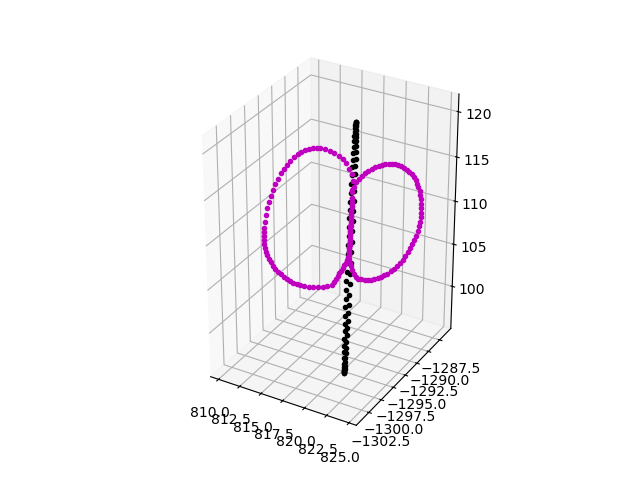

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(otp[:,0],otp[:,1],otp[:,2],'k.')
# ax.plot(westN[:,0],westN[:,1],westN[:,2],'g.')
# ax.plot(westS[:,0],westS[:,1],westS[:,2],'g.')
# ax.plot(eastS[:,0],eastS[:,1],eastS[:,2],'r.')
# ax.plot(eastN[:,0],eastN[:,1],eastN[:,2],'r.')
ax.plot(west[:,0],west[:,1],west[:,2],'.m')
ax.plot(east[:,0],east[:,1],east[:,2],'.m')
ax.set_aspect('equal')

In [10]:
print(f'OTP X dim: {otp[:,0].max()-otp[:,0].min()} (m)')
print(f'OTP Y dim: {otp[:,1].max()-otp[:,1].min()} (m)')
print(f'OTP Z dim: {otp[:,2].max()-otp[:,2].min()} (m)')

OTP X dim: 9.7913818359375 (m)
OTP Y dim: 17.468505859375 (m)
OTP Z dim: 25.975753784179688 (m)


### write a function to find the normal vector to a plane given boundary points of the plane
### get the center, the normal vector, and offset value for the planes

In [10]:

def planeFit(points):
    """
    p, n = planeFit(points)

    Given an array, points, of shape (d,n)
    points in d-dimensional space,
    fit a d-dimensional plane to the points.
    Return a point, p, on the plane (the point-cloud centroid),
    and the normal vector to the plane, n.
    """
    points = np.reshape(points, (np.shape(points)[0], -1)) # Collapse trailing dimensions
    assert points.shape[0] <= points.shape[1], "There are only {} points in {} dimensions.".format(points.shape[1], points.shape[0])
    ctr = points.mean(axis=1)
    x = points - ctr[:,np.newaxis]
    # M = np.dot(x, x.T) # Could also use np.cov(x) here.
    M = np.cov(x)
    normvec = svd(M)[0][:,-1]
    # do the dot product of the center point and the normal vector to find the offset
    fittedPlane = -ctr.dot(normvec)
    return ctr, normvec, fittedPlane
otpctr,otpnormvec,otpfittedPlane = planeFit(otp.T)
wctr,wnormvec,wfittedPlane = planeFit(west.T)
ectr,enormvec,efittedPlane = planeFit(east.T)

### translate hydraulic fractures so they don't intersect otp when extended

In [11]:
# find unit vectors for plane translation 
otpvec = otpctr - (otp[0,0],otp[0,1],otp[0,2])
otpvec = otpvec / -np.linalg.norm(otpvec)
otpvec2 = np.cross(otpnormvec,otpvec)

slide_unit = 6
wvec = wctr - (west[-1,0],west[-1,1],west[-1,2])
wvec = wvec / -np.linalg.norm(wvec)
wvec2 = np.cross(wnormvec,wvec)
west_slide = west + (slide_unit*wvec)
wctr_slide = np.mean(west_slide,axis=0)

evec = ectr - (east[-3,0],east[-3,1],east[-3,2])
evec = evec / -np.linalg.norm(evec)
evec2 = np.cross(enormvec,evec)
east_slide = east + (slide_unit*evec)
ectr_slide = np.mean(east_slide,axis=0)


### increase size of circular planes by some number

In [12]:
def expand_plane(center,points,dist):
    ### P_moved = P + eps*vector ###
    ### P_moved = P + (d / unit_vector)*vector
    npoints = np.empty_like(points)
    cnt = 0
    for i in points:
        v = center - i
        nv = np.sqrt(np.sum((v)**2))
        moved = i + dist*(v/nv)
        npoints[cnt,:] = moved 
        cnt+=1
    return npoints
otp_expand = expand_plane(otpctr,otp,-5)        
west_expand = expand_plane(wctr_slide,west_slide,-5)
east_expand = expand_plane(ectr_slide,east_slide,-5)

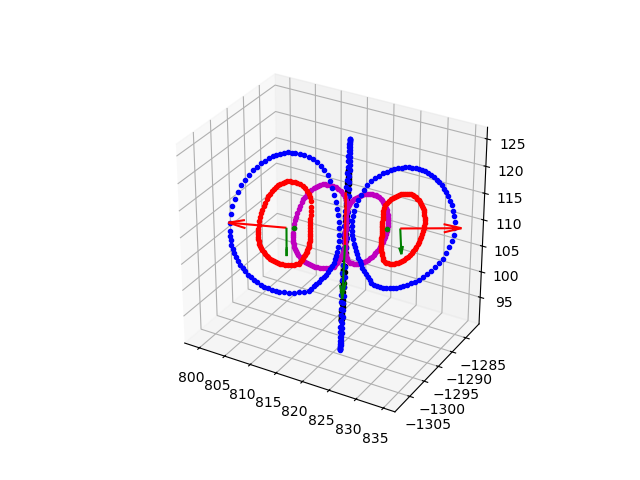

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(otp[:,0],otp[:,1],otp[:,2],'k.')
ax.plot(otp_expand[:,0],otp_expand[:,1],otp_expand[:,2],'.b')
ax.plot(west[:,0],west[:,1],west[:,2],'.m')
ax.plot(east[:,0],east[:,1],east[:,2],'.m')
ax.plot(west_slide[:,0],west_slide[:,1],west_slide[:,2],'.r')
ax.plot(east_slide[:,0],east_slide[:,1],east_slide[:,2],'.r')
ax.plot(west_expand[:,0],west_expand[:,1],west_expand[:,2],'.b')
ax.plot(east_expand[:,0],east_expand[:,1],east_expand[:,2],'.b')
ax.plot(west[-1,0],west[-1,1],west[-1,2],'.g')
ax.plot(east[-3,0],east[-3,1],east[-3,2],'.g')
ax.quiver(wctr_slide[0],wctr_slide[1],wctr_slide[2],wvec[0],wvec[1],wvec[2],color='r',length=10)
ax.quiver(ectr_slide[0],ectr_slide[1],ectr_slide[2],evec[0],evec[1],evec[2],color='r',length=10)
ax.quiver(otpctr[0],otpctr[1],otpctr[2],otpvec[0],otpvec[1],otpvec[2],color='r',length=20)
ax.quiver(wctr_slide[0],wctr_slide[1],wctr_slide[2],wvec2[0],wvec2[1],wvec2[2],color='g',length=5)
ax.quiver(ectr_slide[0],ectr_slide[1],ectr_slide[2],evec2[0],evec2[1],evec2[2],color='g',length=5)
ax.quiver(otpctr[0],otpctr[1],otpctr[2],otpvec2[0],otpvec2[1],otpvec2[2],color='g',length=10)
ax.set_aspect('equal')

In [14]:
def reshape_fracs(points,nr,nc):
    tmp1 = np.flipud(np.arange(nr*nc).reshape(nr,nc)).T
    tmp2 = np.array([points[i] for i in tmp1.flatten()])
    return tmp2

el_step = 6
otp1 = np.array([otpctr + (i*otpvec) for i in np.arange(-17,19,el_step)])
otp2 = np.array([otpctr + (i*otpvec2) for i in np.arange(-17,17,el_step)])
otpsurf_pts = np.array([otp2[i] + (j*otpvec) for i in np.arange(len(otp2)) for j in np.arange(-17,19,el_step)])
otpnr,otpnc = otp2.shape[0],otp1.shape[0]
otpsurf_pts = reshape_fracs(otpsurf_pts,otpnr,otpnc)

w1 = np.array([wctr_slide + (i*wvec) for i in np.arange(-9,15,el_step)])
w2 = np.array([wctr_slide + (i*wvec2) for i in np.arange(-12,12,el_step)])
wsurf_pts = np.array([w2[i] + (j*wvec) for i in np.arange(len(w2)) for j in np.arange(-9,15,el_step)])
wnr,wnc = w2.shape[0],w1.shape[0]
wsurf_pts = reshape_fracs(wsurf_pts,wnr,wnc)

e1 = np.array([ectr_slide + (i*evec) for i in np.arange(-8,15,el_step)])
e2 = np.array([ectr_slide + (i*evec2) for i in np.arange(-12,12,el_step)])
esurf_pts = np.array([e2[i] + (j*evec) for i in np.arange(len(e2)) for j in np.arange(-8,15,el_step)])
enr,enc = e2.shape[0],e1.shape[0]
esurf_pts = reshape_fracs(esurf_pts,enr,enc)

# w1 = np.array([wctr_slide + (i*wvec) for i in np.arange(-9,12,el_step)])
# w2 = np.array([wctr_slide + (i*wvec2) for i in np.arange(-8,8,el_step)])
# wsurf_pts = np.array([w2[i] + (j*wvec) for i in np.arange(len(w2)) for j in np.arange(-9,12,el_step)])
# wnr,wnc = w2.shape[0],w1.shape[0]

# e1 = np.array([ectr_slide + (i*evec) for i in np.arange(-8,12,el_step)])
# e2 = np.array([ectr_slide + (i*evec2) for i in np.arange(-8,8,el_step)])
# esurf_pts = np.array([e2[i] + (j*evec) for i in np.arange(len(e2)) for j in np.arange(-8,12,el_step)])
# enr,enc = e2.shape[0],e1.shape[0]


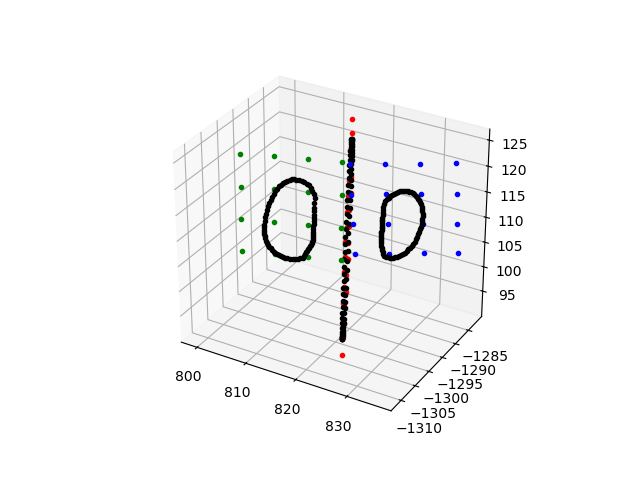

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot(otpsurf_pts[:,0],otpsurf_pts[:,1],otpsurf_pts[:,2],'.r')
ax.plot(otp_expand[:,0],otp_expand[:,1],otp_expand[:,2],'.k')
# ax.plot(otpsurf_pts[0,0],otpsurf_pts[0,1],otpsurf_pts[0,2],'om')
# ax.plot(otpsurf_pts[:5,0],otpsurf_pts[:5,1],otpsurf_pts[:5,2],'om')


ax.plot(wsurf_pts[:,0],wsurf_pts[:,1],wsurf_pts[:,2],'.g')
ax.plot(west_slide[:,0],west_slide[:,1],west_slide[:,2],'k.')
# ax.plot(wsurf_pts[:9,0],wsurf_pts[:9,1],wsurf_pts[:9,2],'om')
# ax.plot(np.array(w1)[:,0],np.array(w1)[:,1],np.array(w1)[:,2],'.r')
# ax.plot(np.array(w2)[:,0],np.array(w2)[:,1],np.array(w2)[:,2],'.k')

ax.plot(esurf_pts[:,0],esurf_pts[:,1],esurf_pts[:,2],'.b')
ax.plot(east_slide[:,0],east_slide[:,1],east_slide[:,2],'k.')
# ax.plot(esurf_pts[:9,0],esurf_pts[:9,1],esurf_pts[:9,2],'om')
# ax.plot(np.array(e1)[:,0],np.array(e1)[:,1],np.array(e1)[:,2],'.r')
# ax.plot(np.array(e2)[:,0],np.array(e2)[:,1],np.array(e2)[:,2],'.k')
ax.set_aspect('equal')

###  use meshgrid to make new points within the plane boundary

In [ ]:
# create points in the plane using the plane EQ
# Ax + By + Cz + D = 0 ... where A, B, C and D are the normal vector components and offset
# use x and z points in the plane to find the y points
# this works much better than using x and y to find z 
# y = -(Ax + Cz + D) / B
# def makeplanepoints(seedPnts,normvec,fittedPlane):
#     xb = np.sort(seedPnts[:,0].copy())
#     zb = np.sort(seedPnts[:,2].copy())
    
#     xx,zz = np.meshgrid(xb,zb)

#     yy = -(normvec[0] * xx + normvec[2] * zz + fittedPlane) * 1. /normvec[1]

#     return xx,yy,zz

# def makeplanepoints_otp(seedPnts,normvec,fittedPlane):
#     yb = np.sort(seedPnts[:,1].copy())
#     zb = np.sort(seedPnts[:,2].copy())
    
#     yy,zz = np.meshgrid(yb,zb)

#     xx = -(normvec[1] * yy + normvec[2] * zz + fittedPlane) * 1. /normvec[0]

#     return xx,yy,zz

# otpxx,otpyy,otpzz = makeplanepoints_otp(otp_expand,otpnormvec,otpfittedPlane)
# wxx,wyy,wzz = makeplanepoints(west_expand,wnormvec,wfittedPlane)
# exx,eyy,ezz = makeplanepoints(east_expand,enormvec,efittedPlane)


In [ ]:
# def fillPlane(x,y,z,tri_size):
#     def myround(x,base=tri_size):
#         return base*np.round(x/base)
#     # find the corners of the plane using corner indices
#     xf = np.array([x[i] for i in list(sliced((0,0,-1,0,-1,-1,0,-1),2))])
#     yf = np.array([y[i] for i in list(sliced((0,0,-1,0,-1,-1,0,-1),2))])
#     zf = np.array([z[i] for i in list(sliced((0,0,-1,0,-1,-1,0,-1),2))])
#     corners = myround(np.concatenate((xf[:,np.newaxis],yf[:,np.newaxis],zf[:,np.newaxis]),axis=1))
#     # extract corner points
#     minlft = np.min(corners[:,0])
#     maxrgt = np.max(corners[:,0])
#     minbot = np.min(corners[:,2])
#     maxtop = np.max(corners[:,2])

#     left = np.linspace(corners[0,:],corners[1,:],int(((maxtop-minbot)//tri_size)+1))
#     top = np.linspace(corners[1,:],corners[2,:],int(((maxrgt-minlft)//tri_size)+1))
#     # right = np.linspace(corners[3,:],corners[2,:],int(((maxtop-minbot)//tri_size)+1))
#     # bot = np.linspace(corners[0,:],corners[3,:],int(((maxrgt-minlft)//tri_size)+1))
#     nr = int(left.shape[0])
#     nc = int(top.shape[0])
#     test = np.tile(left,[nc,1])
#     for i in np.arange(1,nc):
#         idx = slice(int(nr*i),int((nr*i)+nr))
#         test[idx,0] = test[idx,0]+tri_size*i

#     return test,nr,nc

# # numels = [5,5,5]
# numels = [4,4,4]
# # numels = [3,3,3]
# # numels = [2,2,2]

# otpsurf_pts,otpnr,otpnc = fillPlane(otpxx,otpyy,otpzz,tri_size=int(numels[0]))
# wsurf_pts,wnr,wnc = fillPlane(wxx,wyy,wzz,tri_size=int(numels[1]))
# esurf_pts,enr,enc = fillPlane(exx,eyy,ezz,tri_size=int(numels[2]))
# print(f'OTP surf points shape {otpsurf_pts.shape}\n,West surf points shape {wsurf_pts.shape}\n,East surf points shape {esurf_pts.shape}')

### Create a mesh for Ben Thompson's strain matrix function in cutde

In [17]:

# nrows_ncols = [(otpnr,otpnc),(wnnr,wnnc),(wsnr,wsnc),(wdnr,wdnc),(ennr,ennc),(esnr,esnc)]
nrows_ncols = [(otpnr,otpnc),(wnr,wnc),(enr,enc)]
n_els_per_dim =[]
[n_els_per_dim.append((el[0]-1,el[1]-1)) for el in nrows_ncols]
# allsurf_pts = [otpsurf_pts,wnsurf_pts,wssurf_pts,wdsurf_pts,ensurf_pts,essurf_pts]
allsurf_pts = [otpsurf_pts,wsurf_pts,esurf_pts]
num_tri_frac = [2*els[0]*els[1] for els in n_els_per_dim]
def maketris(nr,nc):
    surf_tris =[]
    nx = ny = nr
    idx = lambda i, j: i * ny + j
    for i in range(nc-1):
        for j in range(nr-1):
            # x1, x2 = mesh_xs[i : i + 2]
            # y1, y2 = mesh_ys[j : j + 2]
            surf_tris.append([idx(i, j), idx(i + 1, j), idx(i + 1, j + 1)])
            # print(f'first tri is {[idx(i, j), idx(i + 1, j), idx(i + 1, j + 1)]}')
            surf_tris.append([idx(i, j), idx(i + 1, j + 1), idx(i, j + 1)])
            # print(f'second tri is {[idx(i, j), idx(i + 1, j + 1), idx(i, j + 1)]}')

    surf_tris = np.array(surf_tris, dtype=np.int64)
    return surf_tris

otpsurf_tris = maketris(nr=otpnr,nc=otpnc)
wsurf_tris = maketris(nr=wnr,nc=wnc)
esurf_tris = maketris(nr=enr,nc=enc)

# allsurf_tris = [otpsurf_tris,wnsurf_tris,wssurf_tris,wdsurf_tris,ensurf_tris,essurf_tris]
allsurf_tris = [otpsurf_tris,wsurf_tris,esurf_tris]
allsurf_tri_pts = [pts[allsurf_tris[i]] for i,pts in enumerate(allsurf_pts)]
allsurf_cents=[np.mean(i,axis=1) for i in allsurf_tri_pts]

In [20]:
[print(f'Number of triangles on fracture : {len(i)}') for i in allsurf_tris]

Number of triangles on fracture : 50
Number of triangles on fracture : 18
Number of triangles on fracture : 18


[None, None, None]

In [21]:
print(f'Fracture shapes with squares: {n_els_per_dim}')
[print(f'Number of squares on fracture: {np.prod(i)}') for i in n_els_per_dim]
num_sq_frac = [np.prod(i) for i in n_els_per_dim]

Fracture shapes with squares: [(5, 5), (3, 3), (3, 3)]
Number of squares on fracture: 25
Number of squares on fracture: 9
Number of squares on fracture: 9


In [22]:
def find_tri_center(surf_tris, surf_pnts):
    """ find the center of each triange
    in : surf_tris -- triangle indices for each fault
         surf_pnts -- x, y, z location for each triangle vertex
            
    out: tri_cents -- x, y, z location of each triangle center """
    tri_cents = np.empty(surf_tris.shape)
    for i,tri in enumerate(surf_tris):
        tri_x = (surf_pnts[tri][0][0] + surf_pnts[tri][1][0] + surf_pnts[tri][2][0]) / 3
        tri_y = (surf_pnts[tri][0][1] + surf_pnts[tri][1][1] + surf_pnts[tri][2][1]) / 3
        tri_z = (surf_pnts[tri][0][2] + surf_pnts[tri][1][2] + surf_pnts[tri][2][2]) / 3
        tri_cents[i,0] = tri_x
        tri_cents[i,1] = tri_y
        tri_cents[i,2] = tri_z
    return tri_cents

def dist_to_centers(tri_cents):
    """ find the distance from each triangle center
    to all other triangle centers for each fault """
    return squareform(pdist(tri_cents))

def find_disloc_dim(surf_tris, surf_pnts):
    tri_dims = np.empty(surf_tris.shape[0])
    for i,tri in enumerate(surf_tris):
        tri_x = [surf_pnts[tri][0][0] , surf_pnts[tri][1][0] , surf_pnts[tri][2][0]]
        tri_y = [surf_pnts[tri][0][1] , surf_pnts[tri][1][1] , surf_pnts[tri][2][1]]
        tri_z = [surf_pnts[tri][0][2] , surf_pnts[tri][1][2] , surf_pnts[tri][2][2]]
        l1 = np.sqrt((tri_x[0] - tri_x[1])**2 + (tri_y[0] - tri_y[1])**2 + (tri_z[0]-tri_z[1])**2)
        l2 = np.sqrt((tri_x[1] - tri_x[2])**2 + (tri_y[1] - tri_y[2])**2 + (tri_z[1]-tri_z[2])**2)
        l3 = np.sqrt((tri_x[2] - tri_x[0])**2 + (tri_y[2] - tri_y[0])**2 + (tri_z[2]-tri_z[0])**2)
        p = (l1 + l2 + l3) / 2.0
        tri_area = np.sqrt(p * (p - l1) * (p - l2) * (p - l3))
        tri_dims[i] = tri_area
    return tri_dims

otp_tri_dims = find_disloc_dim(otpsurf_tris,otpsurf_pts)
w_tri_dims = find_disloc_dim(wsurf_tris,wsurf_pts)
e_tri_dims = find_disloc_dim(esurf_tris,esurf_pts)
all_tri_dims = [otp_tri_dims,w_tri_dims,e_tri_dims]

In [27]:
[print(f'{fracList[i]} element area: {round(2*all_tri_dims[i][0])} m**2 and total frac area: {num_sq_frac[i]*round(2*all_tri_dims[i][0])} m**2') for i in range(len(all_tri_dims))]

OTP element area: 36 m**2 and total frac area: 900 m**2
West element area: 36 m**2 and total frac area: 324 m**2
East element area: 36 m**2 and total frac area: 324 m**2


[None, None, None]

In [ ]:
# fig,ax = plt.subplots()
# ax = fig.add_subplot(projection='3d')
# ax.triplot(np.array(wsurf_pts[:,0]),np.array(wsurf_pts[:,2]),np.array(wsurf_tris))
# ax.triplot(np.array(esurf_pts[:,0]),np.array(esurf_pts[:,2]),np.array(esurf_tris))
# ax.plot(wsurf_pts[wsurf_tris][0][0][0],wsurf_pts[wsurf_tris][0][0][2],'.g')
# ax.plot(wsurf_pts[wsurf_tris][0][1][0],wsurf_pts[wsurf_tris][0][1][2],'.r')
# ax.plot(wsurf_pts[wsurf_tris][0][2][0],wsurf_pts[wsurf_tris][0][2][2],'.m')
# ax.plot(wsurf_pts[wsurf_tris][1][2][0],wsurf_pts[wsurf_tris][1][2][2],'.k')

# ax.plot(wsurf_pts[wsurf_tris][1][2][0],wsurf_pts[wsurf_tris][1][2][2],'.g')
# ax.plot(wsurf_pts[wsurf_tris][0][1][0],wsurf_pts[wsurf_tris][0][1][2],'.r')
# ax.plot(wsurf_pts[wsurf_tris][0][2][0],wsurf_pts[wsurf_tris][0][2][2],'.m')
# ax.plot(wsurf_pts[wsurf_tris][1][2][0],wsurf_pts[wsurf_tris][1][2][2],'.k')
# ax.plot(allsurf_cents[0][:,0],allsurf_cents[0][:,1],allsurf_cents[0][:,2],'.c')
# ax.plot(allsurf_cents[1][:,0],allsurf_cents[1][:,1],allsurf_cents[1][:,2],'.c')
# ax.plot(allsurf_cents[2][:,0],allsurf_cents[2][:,1],allsurf_cents[2][:,2],'.c')
# ax.axis('equal')

In [28]:
allstrain_mat = FS.strain_matrix(obs_pts=allpts, tris=np.concatenate([allsurf_pts[i][tri] for i,tri in enumerate(allsurf_tris)],dtype=np.float64),nu=0.22)

In [29]:
def genSlice(sliceLen,nummodes):
    '''Generate a list of slices
    for grabbing the number of 
    triangles in the mesh for each slip mode'''

    first = int(sliceLen / nummodes) 
    second = int(first * 2) 
    third  = int(sliceLen) 
    
    lst = list(sliced((int(0),first,first,second,second,third),2))
    return lst
def fracSlice(start,numfracs):
    '''Generate a list of slices
    for grabbing the number of 
    triangles in the mesh for each indivial fracture'''
    first = start + np.prod(numfracs[0]) 
    second = first + np.prod(numfracs[1]) 
    third  = second + np.prod(numfracs[2]) 
    # fourth = third + np.prod(numfracs[3]) 
    # fifth = fourth + np.prod(numfracs[4]) 
    # sixth = fifth + np.prod(numfracs[5])
    
    # lst = list(sliced((start,first,first,second,second,third,third,fourth,fourth,fifth,fifth,sixth),2))
    lst = list(sliced((start,first,first,second,second,third),2))
    return lst
# slices for splitting the model estimates into their respective modes (strike, dip, tensile)
mode = genSlice((allstrain_mat.shape[2]*allstrain_mat.shape[3])/2,3)
# slices for splitting elements into their respective fracture plane
ifrac = fracSlice(int(mode[0][0]),n_els_per_dim)
jfrac = fracSlice(int(mode[1][0]),n_els_per_dim)
kfrac = fracSlice(int(mode[2][0]),n_els_per_dim)
mfrac = list(zip(ifrac,jfrac,kfrac))

In [30]:
def getRotVecs(points):
    # points in N x 3 
    # convert points to array if list or dataframe
    points = np.array(points)
    # find the derivative of the original points (tangent)
    d_points = np.gradient(points,axis=0)
    # divide by length to get unit tangent
    tangents = d_points / norm(d_points,ord=2)
    # find the derivative of the tangents to get normal
    # d_tans = np.gradient(tangents,axis=1)
    # # divide by length to get unit normal
    # normals = d_tans / norm(d_tans,ord=2)
    # # take cross product to get bi normal
    # bnorms = np.cross(tangents,normals)
    return tangents
    # return tangents,normals,bnorms

pdttans = getRotVecs(pdtpts)
pdbtans = getRotVecs(pdbpts)
psttans = getRotVecs(pstpts)
psbtans = getRotVecs(psbpts)
# ottans = getRotVecs(otpts)
obtans = getRotVecs(obpts)

In [31]:
# Function for doing the strain rotations given the tangent vectors and strains 
# ( See Liam Chiang / Paul Sava paper " High resolution multi-component DAS" )
# Equations in Appendix

def rotStrains(tanvecs,strains):
    R_11 = tanvecs[:,0]
    R_12 = tanvecs[:,1]
    R_13 = tanvecs[:,2]
    
    rotmat = np.zeros((strains.shape[0],strains.shape[2],strains.shape[3]))
    G = np.array([R_11**2, R_12**2, R_13**2, 2*R_11*R_12, 2*R_11*R_13, 2*R_12*R_13]).T
    for i in range(strains.shape[3]):
        for j in range(strains.shape[0]):
            
            rotmat[j,:,i] = G[j,:] @ strains[j,:,:,i]
    return rotmat

first = len(pdtpts)
second = len(pdtpts)+len(pdbpts)
third = second + len(pstpts)
fourth = third + len(psbpts)
fifth = fourth + len(obpts)
# # sixth = fifth + len(obpts)
lenvec = list(sliced((int(0),first,first,second,second,third,third,fourth,fourth,fifth),2))

# Do the rotations

# pdtstrain_mat_rot = rotStrains(pdttans,allstrain_mat[0:len(pdtpts),:,:,:])
pdtstrain_mat_rot = rotStrains(pdttans,allstrain_mat[lenvec[0][0]:lenvec[0][1],:,:,:])
pdbstrain_mat_rot = rotStrains(pdbtans,allstrain_mat[lenvec[1][0]:lenvec[1][1],:,:,:])
pststrain_mat_rot = rotStrains(psttans,allstrain_mat[lenvec[2][0]:lenvec[2][1],:,:,:])
psbstrain_mat_rot = rotStrains(psbtans,allstrain_mat[lenvec[3][0]:lenvec[3][1],:,:,:])
# otstrain_mat_rot = rotStrains(ottans,allstrain_mat[lenvec[4][0]:lenvec[4][1],:,:,:])
obstrain_mat_rot = rotStrains(obtans,allstrain_mat[lenvec[4][0]:lenvec[4][1],:,:,:])

# Combine the rotated strain matrices and make the G matrix for inversion
# allstrain_mat_rot = np.concatenate((pdtstrain_mat_rot,pdbstrain_mat_rot,pststrain_mat_rot,psbstrain_mat_rot,otstrain_mat_rot,obstrain_mat_rot))
allstrain_mat_rot = np.concatenate((pdtstrain_mat_rot,pdbstrain_mat_rot,pststrain_mat_rot,psbstrain_mat_rot,obstrain_mat_rot))
allG = np.hstack((allstrain_mat_rot[:,:,0],allstrain_mat_rot[:,:,1],allstrain_mat_rot[:,:,2]))
# allG = np.hstack((pdtstrain_mat_rot[:,:,0],pdtstrain_mat_rot[:,:,1],pdtstrain_mat_rot[:,:,2]))

### Use a downsampling operator on G to combine triangles into squares

In [32]:
m = allG.shape[1]//3
n = m // 2
dsOp = np.zeros((m,n))
shifts = list(sliced(np.arange(m),2))
for i in range(n):
    dsOp[shifts[i],i] = int(1)
dsOp.shape

(86, 43)

In [33]:
otpx = np.mean(allsurf_cents[0][:,1].reshape(allsurf_cents[0].shape[0] //2,2),axis=1)
otpz = np.mean(allsurf_cents[0][:,2].reshape(allsurf_cents[0].shape[0] //2,2),axis=1)

wx = np.mean(allsurf_cents[1][:,0].reshape(allsurf_cents[1].shape[0] //2,2),axis=1)
wz = np.mean(allsurf_cents[1][:,2].reshape(allsurf_cents[1].shape[0] //2,2),axis=1)

ex = np.mean(allsurf_cents[2][:,0].reshape(allsurf_cents[2].shape[0] //2,2),axis=1)
ez = np.mean(allsurf_cents[2][:,2].reshape(allsurf_cents[2].shape[0] //2,2),axis=1)

In [34]:
def makeSlips(xvals,yvals,A=1):
    # xmean = np.mean(xvals)
    # ymean = np.mean(yvals)
    # xstd = np.std(xvals)
    # ystd = np.std(yvals)
    x = xvals - np.mean(xvals)
    z = yvals - np.mean(yvals)
    
    # return A * np.exp(-((xvals - xmean)**2) / 2*(xstd**2) + ((yvals - ymean)**2) / 2*(ystd**2))
    return A*np.exp((-x**2 - z**2)/10) + 0.1

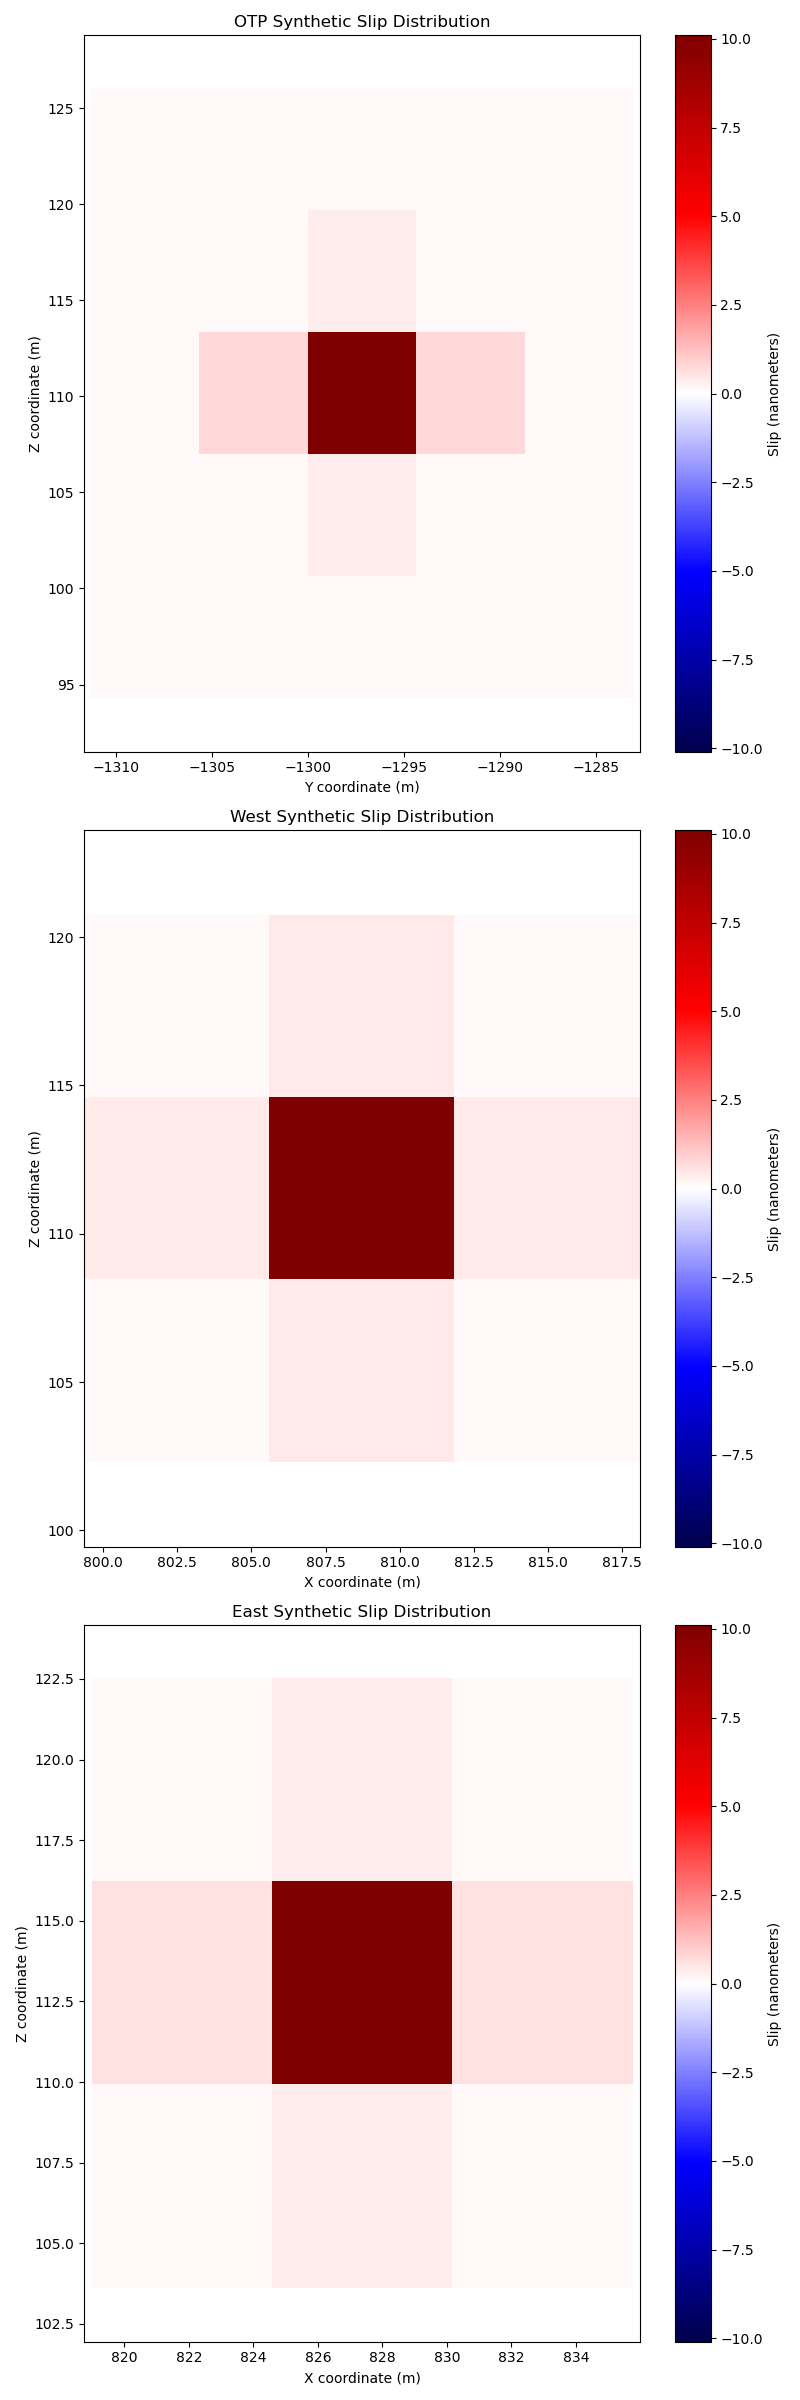

In [35]:

otpslip_mat = makeSlips(xvals=otpx,yvals=otpz,A=10)
# wnslip_mat = makeSlips(xvals=wnx,yvals=wnz,A=10)
wslip_mat = makeSlips(xvals=wx,yvals=wz,A=10)
# wdslip_mat = makeSlips(xvals=wdx,yvals=wdz,A=10)
# enslip_mat = makeSlips(xvals=enx,yvals=enz,A=10)
eslip_mat = makeSlips(xvals=ex,yvals=ez,A=10)


fig,ax = plt.subplots(3,1,figsize=(8,24))

im0 = ax[0].imshow(otpslip_mat.reshape(n_els_per_dim[0],order='F'),aspect='auto',\
    extent=[otpsurf_pts[:,1].min(),otpsurf_pts[:,1].max(),otpsurf_pts[:,2].min(),otpsurf_pts[:,2].max()],\
        vmin=-np.max(otpslip_mat),vmax=np.max(otpslip_mat),cmap='seismic')
ax[0].set_xlabel('Y coordinate (m)')
ax[0].set_ylabel('Z coordinate (m)')
ax[0].set_title('OTP Synthetic Slip Distribution')
ax[0].axis('equal')
cbar0 = plt.colorbar(im0,ax=ax[0])
cbar0.ax.set_ylabel('Slip (nanometers)')

# im1 = ax[1].imshow(wnslip_mat.reshape(n_els_per_dim[1],order='F'),aspect='auto',\
#     extent=[wnsurf_pts[:,0].min(),wnsurf_pts[:,0].max(),wnsurf_pts[:,2].min(),wnsurf_pts[:,2].max()],\
#         vmin=-np.max(wnslip_mat),vmax=np.max(wnslip_mat),cmap='seismic')
# ax[1].set_xlabel('X coordinate (m)')
# ax[1].set_ylabel('Z coordinate (m)')
# ax[1].set_title('WN Synthetic Slip Distribution')
# ax[1].axis('equal')
# cbar1 = plt.colorbar(im1,ax=ax[1])
# cbar1.ax.set_ylabel('Slip (nanometers)')

im2 = ax[1].imshow(wslip_mat.reshape(n_els_per_dim[1],order='F'),aspect='auto',\
    extent=[wsurf_pts[:,0].min(),wsurf_pts[:,0].max(),wsurf_pts[:,2].min(),wsurf_pts[:,2].max()],\
        vmin=-np.max(wslip_mat),vmax=np.max(wslip_mat),cmap='seismic')
ax[1].set_xlabel('X coordinate (m)')
ax[1].set_ylabel('Z coordinate (m)')
ax[1].set_title('West Synthetic Slip Distribution')
ax[1].axis('equal')
cbar2 = plt.colorbar(im2,ax=ax[1])
cbar2.ax.set_ylabel('Slip (nanometers)')

# im3 = ax[3].imshow(wdslip_mat.reshape(n_els_per_dim[3],order='F'),aspect='auto',\
#     extent=[wdsurf_pts[:,0].min(),wdsurf_pts[:,0].max(),wdsurf_pts[:,2].min(),wdsurf_pts[:,2].max()],\
#         vmin=-np.max(wdslip_mat),vmax=np.max(wdslip_mat),cmap='seismic')
# ax[3].set_xlabel('X coordinate (m)')
# ax[3].set_ylabel('Z coordinate (m)')
# ax[3].set_title('WD Synthetic Slip Distribution')
# ax[3].axis('equal')
# cbar3 = plt.colorbar(im3,ax=ax[3])
# cbar3.ax.set_ylabel('Slip (nanometers)')

# im4 = ax[2].imshow(enslip_mat.reshape(n_els_per_dim[2],order='F'),aspect='auto',\
#     extent=[ensurf_pts[:,0].min(),ensurf_pts[:,0].max(),ensurf_pts[:,2].min(),ensurf_pts[:,2].max()],\
#         vmin=-np.max(enslip_mat),vmax=np.max(enslip_mat),cmap='seismic')
# ax[4].set_xlabel('X coordinate (m)')
# ax[4].set_ylabel('Z coordinate (m)')
# ax[4].set_title('EN Synthetic Slip Distribution')
# ax[4].axis('equal')
# cbar4 = plt.colorbar(im4,ax=ax[2])
# cbar4.ax.set_ylabel('Slip (nanometers)')

im5 = ax[2].imshow(eslip_mat.reshape(n_els_per_dim[2],order='F'),aspect='auto',\
    extent=[esurf_pts[:,0].min(),esurf_pts[:,0].max(),esurf_pts[:,2].min(),esurf_pts[:,2].max()],\
        vmin=-np.max(eslip_mat),vmax=np.max(eslip_mat),cmap='seismic')
ax[2].set_xlabel('X coordinate (m)')
ax[2].set_ylabel('Z coordinate (m)')
ax[2].set_title('East Synthetic Slip Distribution')
ax[2].axis('equal')
cbar5 = plt.colorbar(im5,ax=ax[2])
cbar5.ax.set_ylabel('Slip (nanometers)')
fig.tight_layout()

In [36]:

first = int(allG.shape[1]/3)
sec =2*int(allG.shape[1]/3)
tmpGss = allG[:,:first] @ dsOp
tmpGds = allG[:,first:sec] @ dsOp
tmpGts = allG[:,sec:] @ dsOp
newG = np.hstack((tmpGss,tmpGds,tmpGts))

otpmtest = np.tile(otpslip_mat.flatten(),3)
# wnmtest = np.tile(wnslip_mat.flatten(),3)
wmtest = np.tile(wslip_mat.flatten(),3)
# wdmtest = np.tile(wdslip_mat.flatten(),3)
# enmtest = np.tile(enslip_mat.flatten(),3)
emtest = np.tile(eslip_mat.flatten(),3)
# all_mtest = np.concatenate((otpmtest,wnmtest,wsmtest,wdmtest,enmtest,esmtest))
all_mtest = np.concatenate((otpmtest,wmtest,emtest))
dtest = newG @ all_mtest
dtest_ts = newG[:,(sec//2):] @ all_mtest[(sec//2):]
dtest_ds = newG[:,(first//2):(sec//2)] @ all_mtest[(first//2):(sec//2)]
dtest_ss = newG[:,:(first//2)] @ all_mtest[:(first//2)]

In [37]:
# Definitions for Ridge Regression 

def ridge(X, y, l2):
    """Ridge Regression model with intercept term.
    L2 penalty and intercept term included via design matrix augmentation.
    Params:
        X - NumPy matrix, size (N, p), of numerical predictors
        y - NumPy array, length N, of numerical response
        l2 - L2 penalty tuning parameter (positive scalar) 
    Returns:
        NumPy array, length p + 1, of fitted model coefficients
    """
    m, n = np.shape(X)
    upper_half = np.hstack((np.ones((m, 1)), X))
    # upper_half = X
    lower = np.zeros((n, n))
    np.fill_diagonal(lower, np.sqrt(l2))
    lower_half = np.hstack((np.zeros((n, 1)), lower))
    # lower_half = lower
    X = np.vstack((upper_half, lower_half))
    y = np.append(y, np.zeros(n))
    if m == n:
        soln = solve(np.dot(X.T, X), np.dot(X.T, y))
    else:
        soln = lstsq(np.dot(X.T, X), np.dot(X.T, y))
        U,s,Vt = svd(np.dot(X.T, X),lapack_driver='gesvd')
        # soln = lstsq(X, y)
        # U,s,Vt = svd(X)
        
    return soln, U, s, Vt, X, y

def getCond(X, y, l2):
    """ Find condition number of augmented matrix for Ridge 
    L2 penalty and intercept term included via design matrix augmentation.
    Params:
        X - NumPy matrix, size (N, p), of numerical predictors
        y - NumPy array, length N, of numerical response
        l2 - L2 penalty tuning parameter (positive scalar) 
    Returns:
        NumPy array, length p + 1, of fitted model coefficients
    """
    m, n = np.shape(X)
    upper_half = np.hstack((np.ones((m, 1)), X))
    lower = np.zeros((n, n))
    np.fill_diagonal(lower, np.sqrt(l2))
    lower_half = np.hstack((np.zeros((n, 1)), lower))
    X = np.vstack((upper_half, lower_half))
    
    condition_num = np.linalg.cond(np.dot(X.T, X))
    return condition_num

In [39]:
print(f'Elements in Slip Mode: {mode}\n, SSlip: {ifrac}\n, DSlip: {jfrac}\n, Tensile: {kfrac}\n, Combined: {mfrac}')

Elements in Slip Mode: [(0, 43), (43, 86), (86, 129)]
, SSlip: [(0, 25), (25, 34), (34, 43)]
, DSlip: [(43, 68), (68, 77), (77, 86)]
, Tensile: [(86, 111), (111, 120), (120, 129)]
, Combined: [((0, 25), (43, 68), (86, 111)), ((25, 34), (68, 77), (111, 120)), ((34, 43), (77, 86), (120, 129))]


In [40]:
lam = 1e-13 # avg lambda for stims 4 and 5
# mest,U,s,Vt, G, daty = ridge(allG, dtest,lam)
mest,_,_,_,_,_ = ridge(newG, dtest,lam)
mest_ss,_,_,_,_,_ = ridge(newG[:,:(first//2)], dtest_ss,lam)
mest_ds,_,_,_,_,_  = ridge(newG[:,(first//2):(sec//2)], dtest_ds,lam)
mest_ts,_,_,_,_,_  = ridge(newG[:,(sec//2):], dtest_ts,lam)
mest = mest[0][1:].copy()
mestts = mest_ts[0][1:].copy()
mestss = mest_ss[0][1:].copy()
mestds = mest_ds[0][1:].copy()

## Calculate MSE for inversions
def calc_mse(actual,estimated,n=None):
    return norm(actual - estimated) / norm(actual)

def calc_mape(actual,estimated,n=None):
    return 100*(np.sum(np.abs((actual - estimated) / actual)) / n)

# mse_all_ss = np.empty((len(fracList),1))
# mse_all_ds = np.empty((len(fracList),1))
# mse_all_ts = np.empty((len(fracList),1))
# mse_ss = np.empty((len(fracList),1))
# mse_ds = np.empty((len(fracList),1))
# mse_ts = np.empty((len(fracList),1))

mape_all_ss = np.empty((len(fracList),1))
mape_all_ds = np.empty((len(fracList),1))
mape_all_ts = np.empty((len(fracList),1))
mape_ss = np.empty((len(fracList),1))
mape_ds = np.empty((len(fracList),1))
mape_ts = np.empty((len(fracList),1))

# for i in range(len(fracList)):

#     mse_all_ss[i] = calc_mse(all_mtest[ifrac[i][0]:ifrac[i][1]],mest[ifrac[i][0]:ifrac[i][1]])
#     mse_all_ds[i] = calc_mse(all_mtest[jfrac[i][0]:jfrac[i][1]],mest[jfrac[i][0]:jfrac[i][1]])
#     mse_all_ts[i] = calc_mse(all_mtest[kfrac[i][0]:kfrac[i][1]],mest[kfrac[i][0]:kfrac[i][1]])
#     mse_ss[i] = calc_mse(all_mtest[ifrac[i][0]:ifrac[i][1]],mestss[ifrac[i][0]:ifrac[i][1]])
#     mse_ds[i] = calc_mse(all_mtest[jfrac[i][0]:jfrac[i][1]],mestds[ifrac[i][0]:ifrac[i][1]])
#     mse_ts[i] = calc_mse(all_mtest[kfrac[i][0]:kfrac[i][1]],mestts[ifrac[i][0]:ifrac[i][1]])
for i in range(len(fracList)):

    mape_all_ss[i] = calc_mape(all_mtest[ifrac[i][0]:ifrac[i][1]],mest[ifrac[i][0]:ifrac[i][1]],n=num_sq_frac[i])
    mape_all_ds[i] = calc_mape(all_mtest[jfrac[i][0]:jfrac[i][1]],mest[jfrac[i][0]:jfrac[i][1]],n=num_sq_frac[i])
    mape_all_ts[i] = calc_mape(all_mtest[kfrac[i][0]:kfrac[i][1]],mest[kfrac[i][0]:kfrac[i][1]],n=num_sq_frac[i])
    mape_ss[i] = calc_mape(all_mtest[ifrac[i][0]:ifrac[i][1]],mestss[ifrac[i][0]:ifrac[i][1]],n=num_sq_frac[i])
    mape_ds[i] = calc_mape(all_mtest[jfrac[i][0]:jfrac[i][1]],mestds[ifrac[i][0]:ifrac[i][1]],n=num_sq_frac[i])
    mape_ts[i] = calc_mape(all_mtest[kfrac[i][0]:kfrac[i][1]],mestts[ifrac[i][0]:ifrac[i][1]],n=num_sq_frac[i])

In [41]:
# print(f'MSE_all_ss: {mse_all_ss} \n MSE_all_ds: {mse_all_ds} \n MSE_all_ts: {mse_all_ts} \
# \n MSE_ss: {mse_ss} \n MSE_ds: {mse_ds} \n MSE_ts: {mse_ts}')
print(f'MAPE_all_ss: {mape_all_ss} \n MAPE_all_ds: {mape_all_ds} \n MAPE_all_ts: {mape_all_ts} \
\n MAPE_ss: {mape_ss} \n MAPE_ds: {mape_ds} \n MAPE_ts: {mape_ts}')

MAPE_all_ss: [[268.07732391]
 [264.35738474]
 [ 50.64219721]] 
 MAPE_all_ds: [[378.80013617]
 [313.04413494]
 [103.2360952 ]] 
 MAPE_all_ts: [[154.94523655]
 [147.43737591]
 [ 98.58542738]] 
 MAPE_ss: [[0.06088825]
 [0.0594608 ]
 [0.01065167]] 
 MAPE_ds: [[0.11376723]
 [0.16128193]
 [0.02853408]] 
 MAPE_ts: [[0.06041074]
 [0.01723831]
 [0.0102025 ]]


In [ ]:
# mse_162 = [mse_all_ss,mse_all_ds,mse_all_ts,mse_ss,mse_ds,mse_ts]
# with open('/home/spri902/EGS_Collab/4850/results/maystim/mesh_analysis/allfracs_allboreholes/mse_162_frac.npy','wb') as f:
#     np.save(f,mse_162)

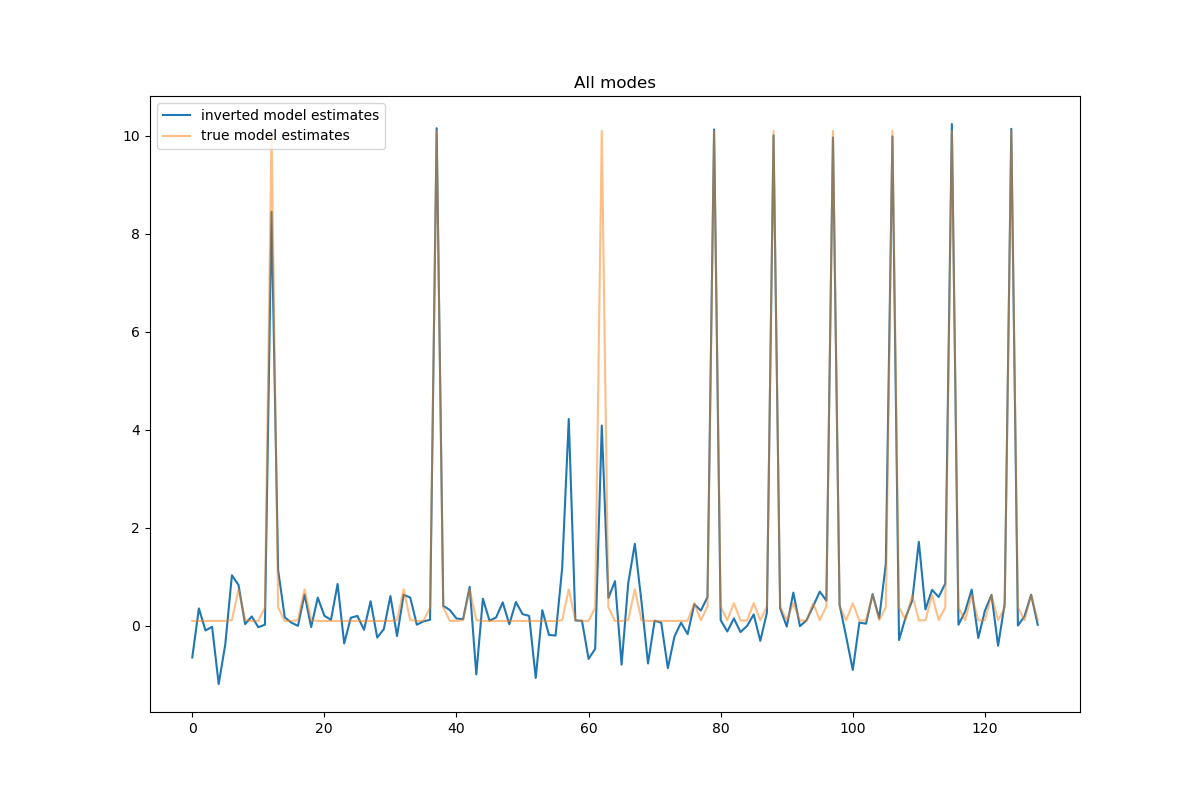

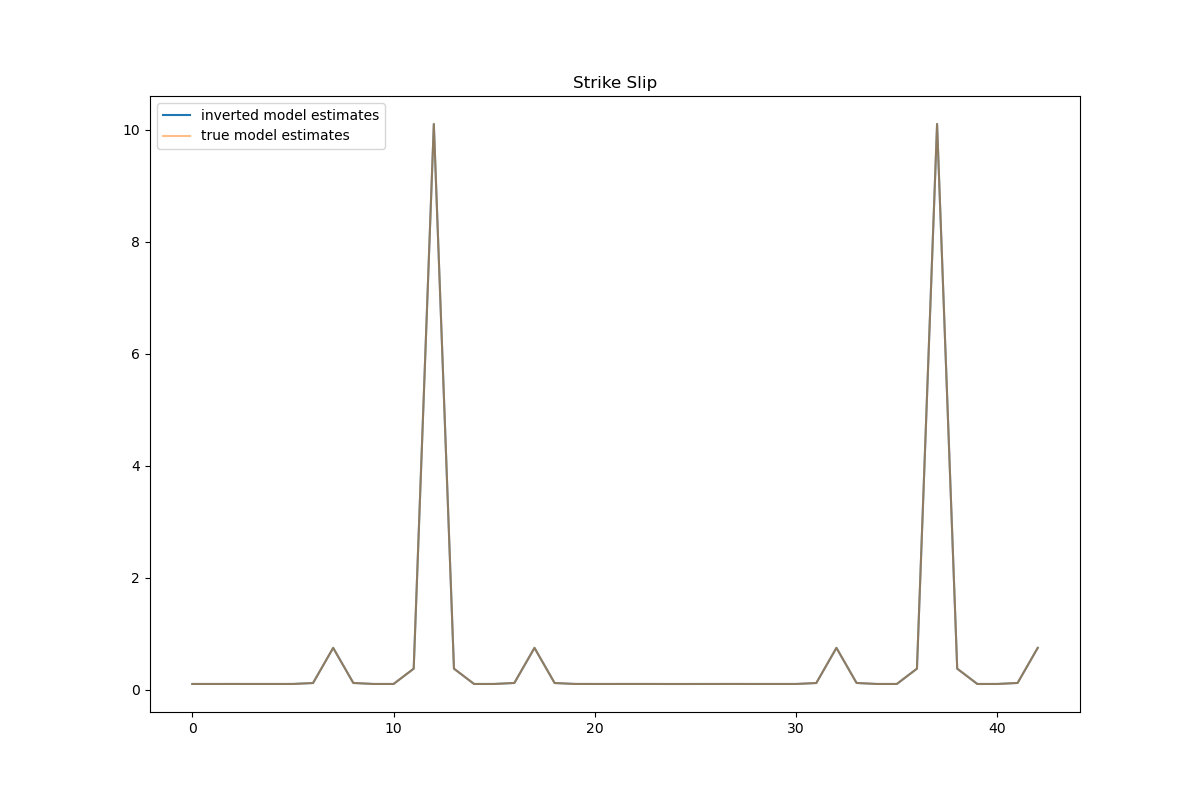

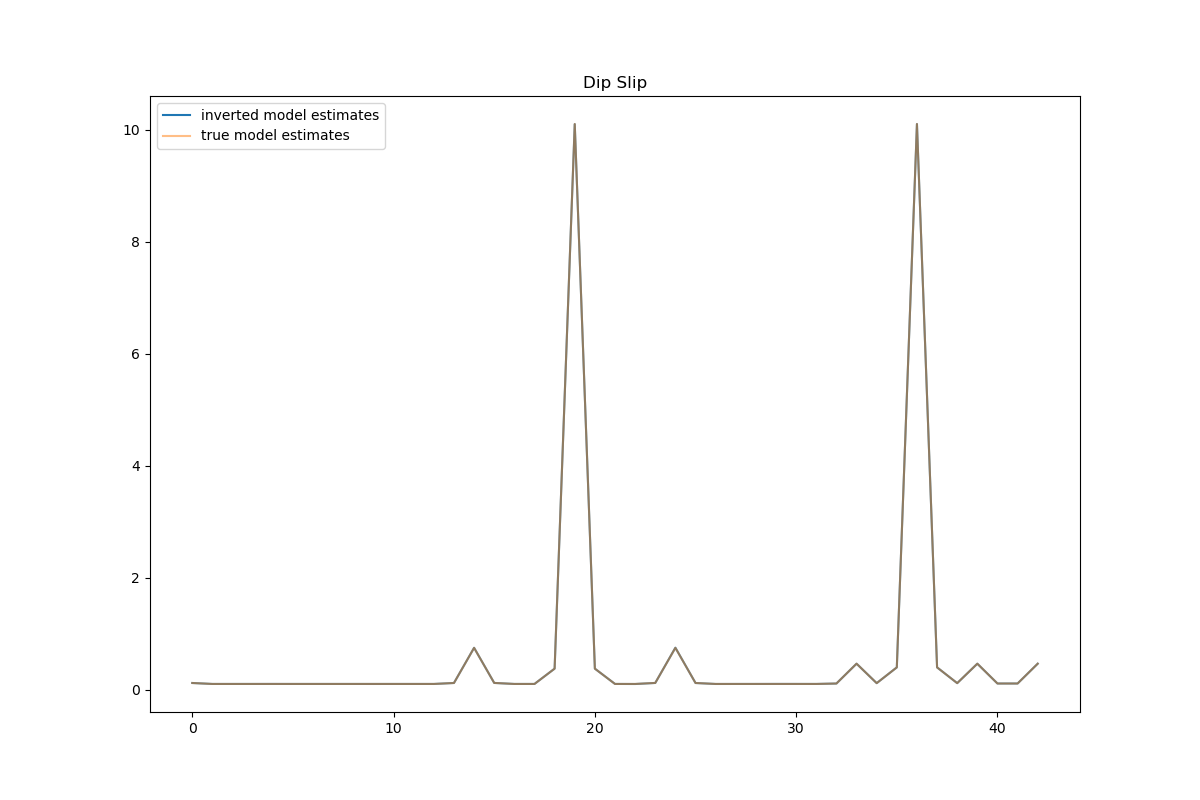

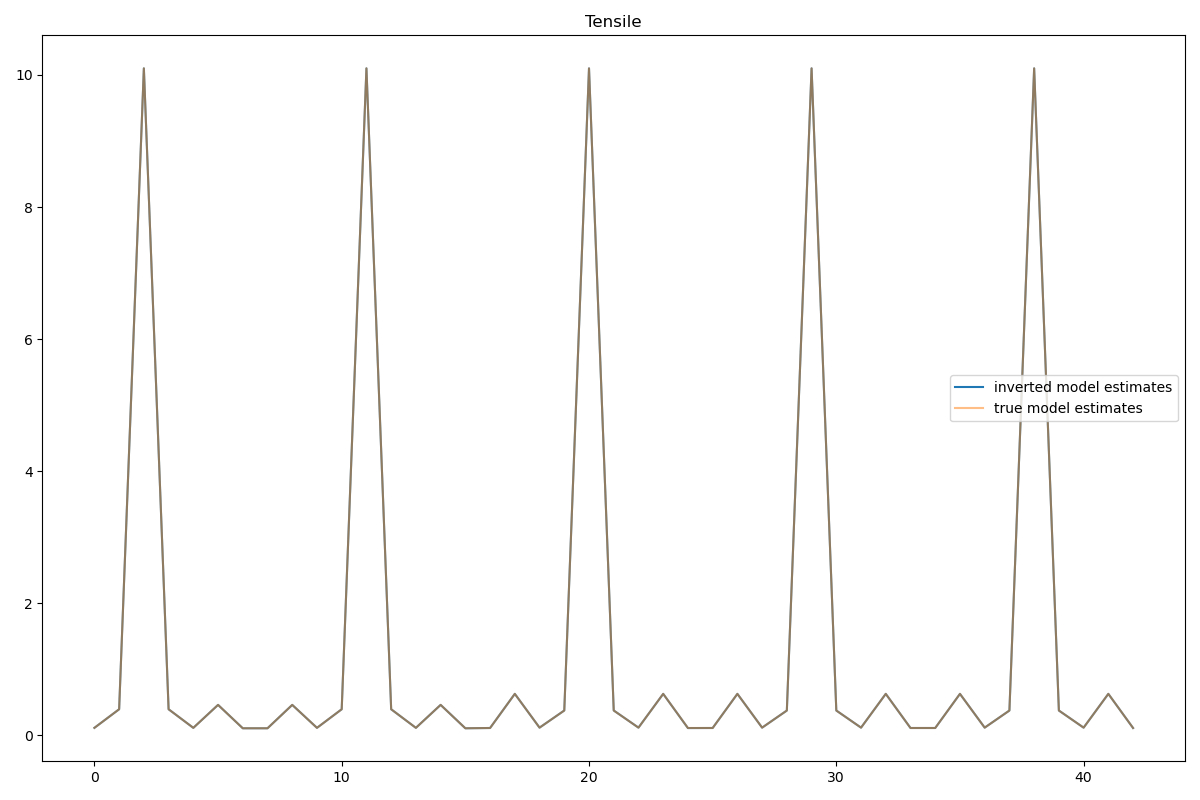

In [42]:
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(mest,label='inverted model estimates')
ax.plot(all_mtest,label='true model estimates',alpha=0.5)
ax.legend()
ax.set_title('All modes')
fig.tight_layout
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(mestss,label='inverted model estimates')
ax.plot(all_mtest[:(first//2)],label='true model estimates',alpha=0.5)
ax.legend()
ax.set_title('Strike Slip')
fig.tight_layout
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(mestds,label='inverted model estimates')
ax.plot(all_mtest[first//2:sec//2],label='true model estimates',alpha=0.5)
ax.legend()
ax.set_title('Dip Slip')
fig.tight_layout
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(mestts,label='inverted model estimates')
ax.plot(all_mtest[sec//2:],label='true model estimates',alpha=0.5)
ax.legend()
ax.set_title('Tensile')
fig.tight_layout()

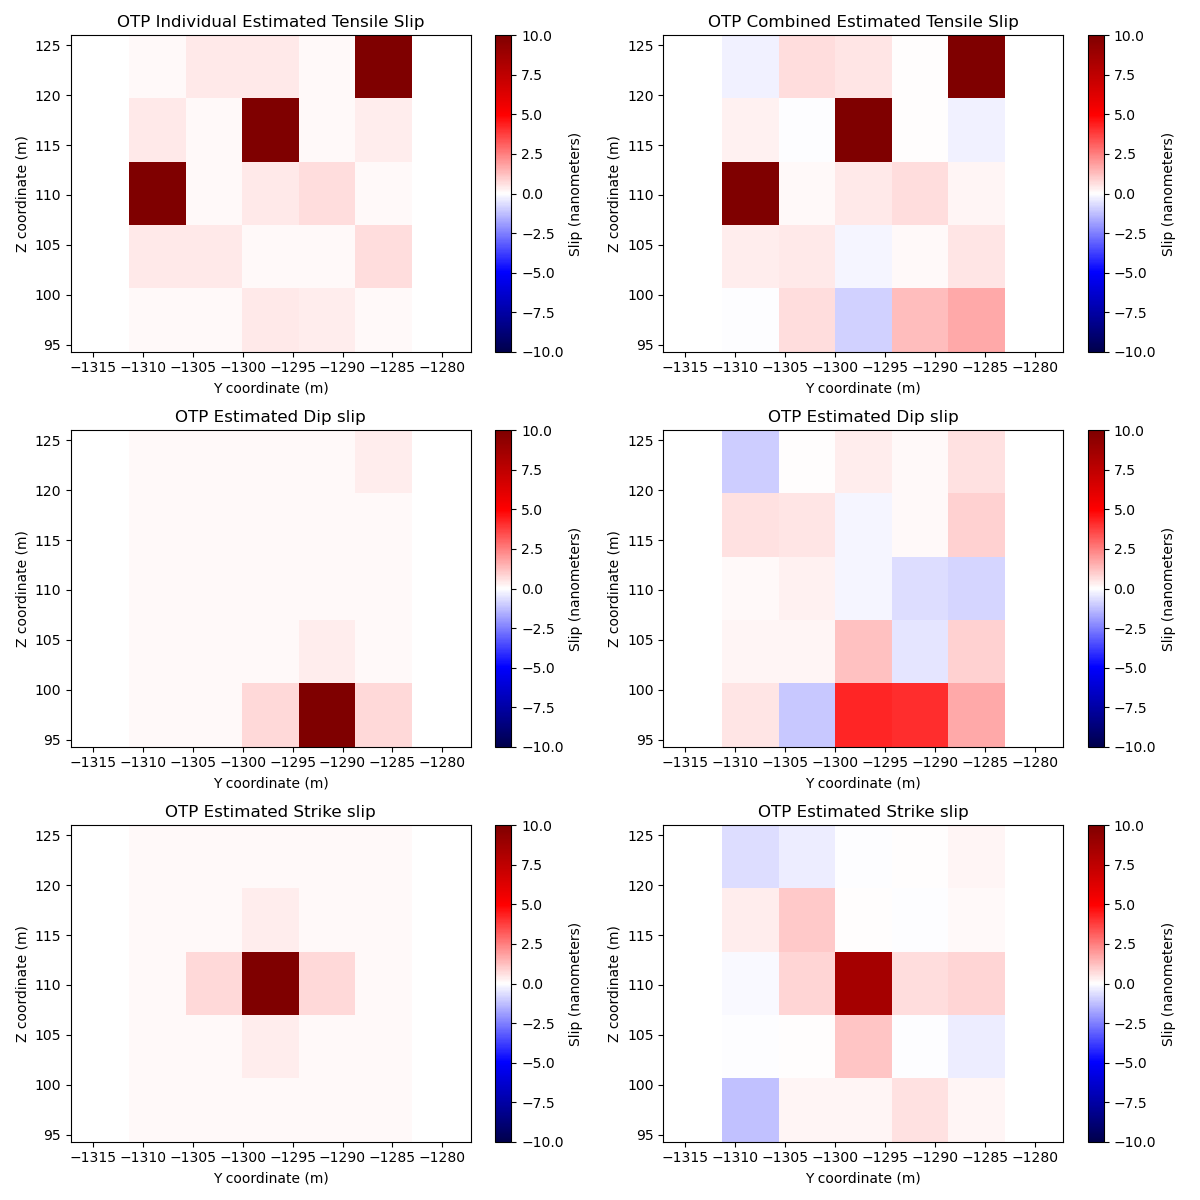

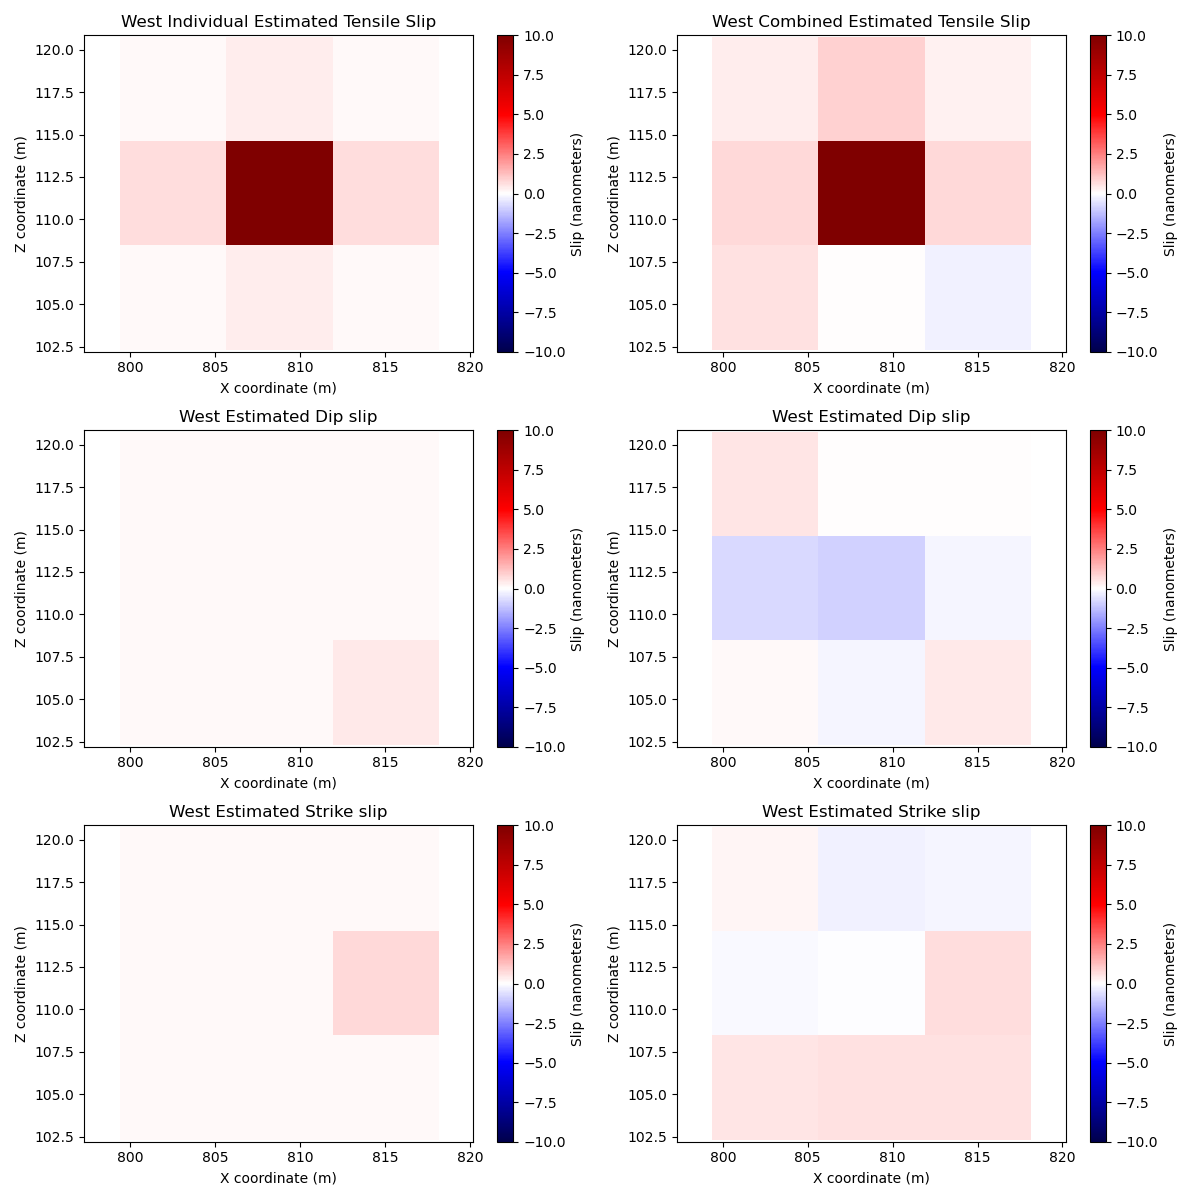

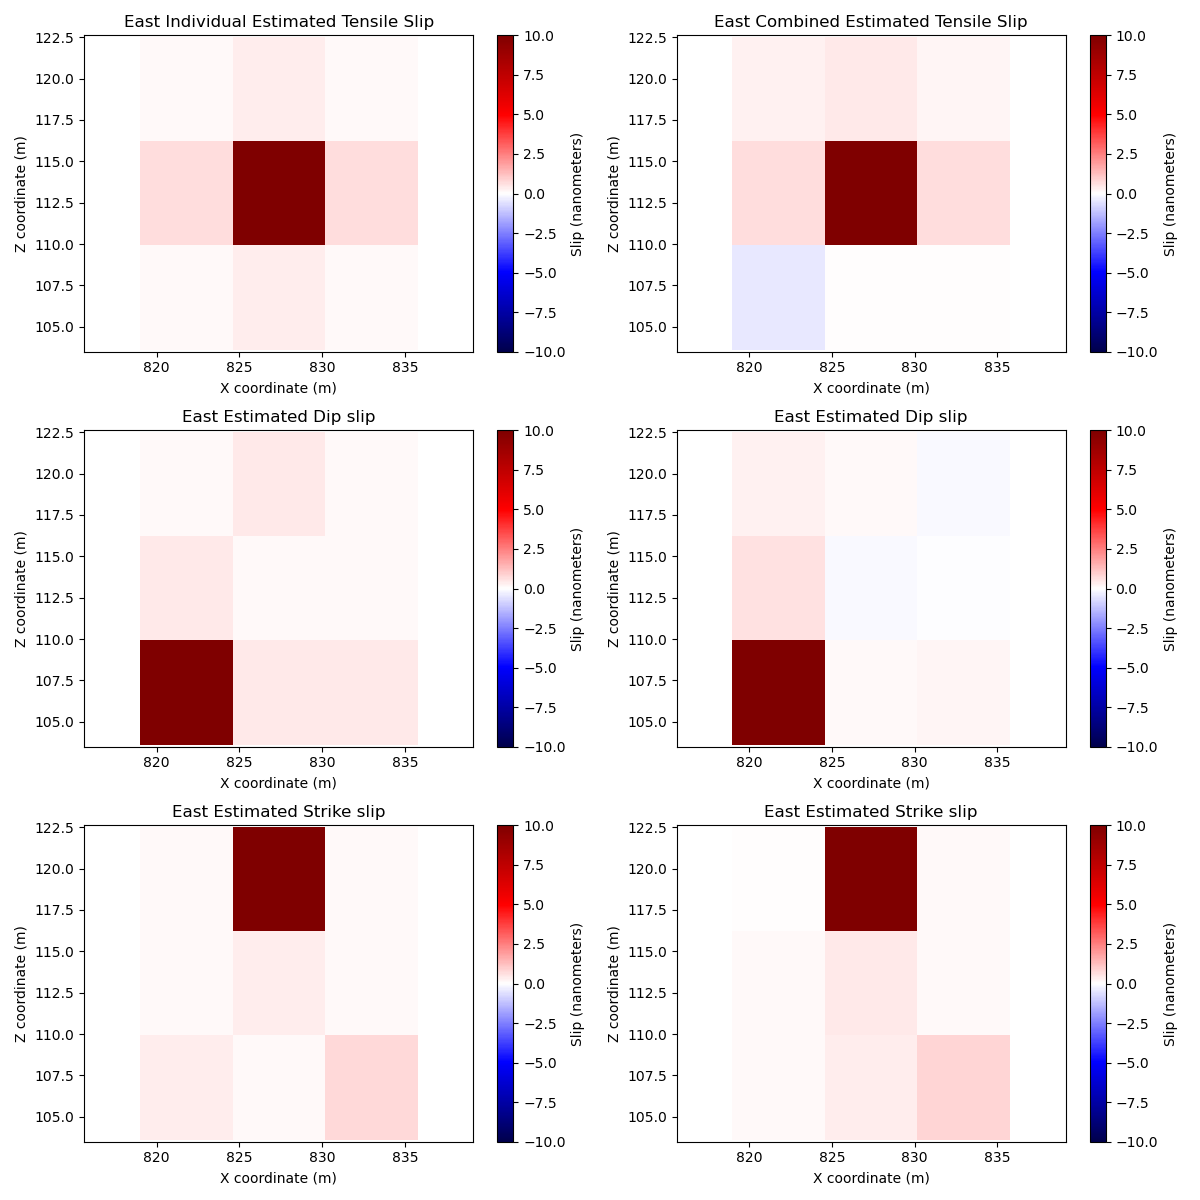

In [43]:
vm = 10
for i in range(len(fracList)):
    
    fig,ax=plt.subplots(3,2,figsize=(12,12))
    ## 00
    if i ==0:
        # fig.suptitle(f'{np.prod(n_els_per_dim[i])} Elements in Mesh')
        im00 = ax[0,0].imshow(mestts[ifrac[i][0]:ifrac[i][1]].reshape(n_els_per_dim[i],order='F'),vmin = -vm,vmax=vm,cmap='seismic',\
        extent=[allsurf_pts[i][:,1].min(),allsurf_pts[i][:,1].max(),allsurf_pts[i][:,2].min(),allsurf_pts[i][:,2].max()],label=f'MSE: {np.round(mape_ts,decimals=2)}')
        ax[0,0].set_title(f'{fracList[i]} Individual Estimated Tensile Slip')
        ax[0,0].set_xlabel('Y coordinate (m)')
        ax[0,0].set_ylabel('Z coordinate (m)')
        ax[0,0].axis('equal')
        # legend = ax[0,0].legend(loc=3,frameon = 1,facecolor='white')
        # frame = legend.get_frame()
        # frame.set_facecolor('white')
        cbar00 = plt.colorbar(im00,ax=ax[0,0])
        cbar00.ax.set_ylabel('Slip (nanometers)')
        # cbar00.set_ticks(np.linspace(0,np.ceil(np.max(mestts)),6))
        ## 01
        im01 = ax[0,1].imshow(mest[kfrac[i][0]:kfrac[i][1]].reshape(n_els_per_dim[i],order='F'),vmin = -vm,vmax=vm,cmap='seismic',\
        extent=[allsurf_pts[i][:,1].min(),allsurf_pts[i][:,1].max(),allsurf_pts[i][:,2].min(),allsurf_pts[i][:,2].max()],label=f'MSE: {np.round(mape_ts,decimals=2)}')
        ax[0,1].set_title(f'{fracList[i]} Combined Estimated Tensile Slip')
        ax[0,1].set_xlabel('Y coordinate (m)')
        ax[0,1].set_ylabel('Z coordinate (m)')
        ax[0,1].axis('equal')
        # legend = ax[0,1].legend(loc=3,frameon = 1)
        # frame = legend.get_frame()
        # frame.set_facecolor('white')
        cbar01 = plt.colorbar(im01,ax=ax[0,1])
        cbar01.ax.set_ylabel('Slip (nanometers)')
        # cbar01.set_ticks(np.linspace(0,np.floor(np.max(mest[sec:])),6))
        im10 = ax[1,0].imshow(mestds[ifrac[i][0]:ifrac[i][1]].reshape(n_els_per_dim[i],order='F'),vmin = -vm,vmax=vm,cmap='seismic',\
        extent=[allsurf_pts[i][:,1].min(),allsurf_pts[i][:,1].max(),allsurf_pts[i][:,2].min(),allsurf_pts[i][:,2].max()],label=f'MSE: {np.round(mape_ts,decimals=2)}')
        ax[1,0].set_title(f'{fracList[i]} Estimated Dip slip')
        ax[1,0].set_xlabel('Y coordinate (m)')
        ax[1,0].set_ylabel('Z coordinate (m)')
        ax[1,0].axis('equal')
        # legend = ax[1,0].legend(loc=3,frameon = 1)
        # frame = legend.get_frame()
        # frame.set_facecolor('white')
        cbar10 = plt.colorbar(im10,ax=ax[1,0])
        cbar10.ax.set_ylabel('Slip (nanometers)')
        # cbar10.set_ticks(np.linspace(0,np.ceil(np.max(mestds)),6))
        ## 11
        im11 = ax[1,1].imshow(mest[jfrac[i][0]:jfrac[i][1]].reshape(n_els_per_dim[i],order='F'),vmin = -vm,vmax=vm,cmap='seismic',\
        extent=[allsurf_pts[i][:,1].min(),allsurf_pts[i][:,1].max(),allsurf_pts[i][:,2].min(),allsurf_pts[i][:,2].max()],label=f'MSE: {np.round(mape_ts,decimals=2)}')
        ax[1,1].set_title(f'{fracList[i]} Estimated Dip slip')
        ax[1,1].set_xlabel('Y coordinate (m)')
        ax[1,1].set_ylabel('Z coordinate (m)')
        ax[1,1].axis('equal')
        # legend = ax[1,1].legend(loc=3,frameon = 1)
        # frame = legend.get_frame()
        # frame.set_facecolor('white')
        cbar11 = plt.colorbar(im11,ax=ax[1,1])
        cbar11.ax.set_ylabel('Slip (nanometers)')
        # cbar11.set_ticks(np.linspace(0,np.ceil(np.max(mest[first:sec])),6))
        ## 20
        im20 = ax[2,0].imshow(mestss[ifrac[i][0]:ifrac[i][1]].reshape(n_els_per_dim[i],order='F'),vmin = -vm,vmax=vm,cmap='seismic',\
        extent=[allsurf_pts[i][:,1].min(),allsurf_pts[i][:,1].max(),allsurf_pts[i][:,2].min(),allsurf_pts[i][:,2].max()],label=f'MSE: {np.round(mape_ts,decimals=2)}')
        ax[2,0].set_title(f'{fracList[i]} Estimated Strike slip')
        ax[2,0].set_xlabel('Y coordinate (m)')
        ax[2,0].set_ylabel('Z coordinate (m)')
        ax[2,0].axis('equal')
        # legend = ax[2,0].legend(loc=3,frameon = 1)
        # frame = legend.get_frame()
        # frame.set_facecolor('white')
        cbar20 = plt.colorbar(im20,ax=ax[2,0])
        cbar20.ax.set_ylabel('Slip (nanometers)')
        # cbar20.set_ticks(np.linspace(0,np.ceil(np.max(mestss)),6))
        # 21
        im21 = ax[2,1].imshow(mest[ifrac[i][0]:ifrac[i][1]].reshape(n_els_per_dim[i],order='F'),vmin = -vm,vmax=vm,cmap='seismic',\
        extent=[allsurf_pts[i][:,1].min(),allsurf_pts[i][:,1].max(),allsurf_pts[i][:,2].min(),allsurf_pts[i][:,2].max()],label=f'MSE: {np.round(mape_ts,decimals=2)}')
        ax[2,1].set_title(f'{fracList[i]} Estimated Strike slip')
        ax[2,1].set_xlabel('Y coordinate (m)')
        ax[2,1].set_ylabel('Z coordinate (m)')
        ax[2,1].axis('equal')
        # legend = ax[2,1].legend(loc=3,frameon = 1)
        # frame = legend.get_frame()
        # frame.set_facecolor('white')
        cbar21 = plt.colorbar(im21,ax=ax[2,1])
        cbar21.ax.set_ylabel('Slip (nanometers)')
        # cbar21.set_ticks(np.linspace(0,np.ceil(np.max(mest[:first])),6))
        fig.tight_layout()
    else:
        # fig.suptitle(f'{np.prod(n_els_per_dim[i])} Elements in Mesh')
        im00 = ax[0,0].imshow(mestts[ifrac[i][0]:ifrac[i][1]].reshape(n_els_per_dim[i],order='F'),vmin = -vm,vmax=vm,cmap='seismic',\
        extent=[allsurf_pts[i][:,0].min(),allsurf_pts[i][:,0].max(),allsurf_pts[i][:,2].min(),allsurf_pts[i][:,2].max()],label=f'MSE: {np.round(mape_ts,decimals=2)}')
        ax[0,0].set_title(f'{fracList[i]} Individual Estimated Tensile Slip')
        ax[0,0].set_xlabel('X coordinate (m)')
        ax[0,0].set_ylabel('Z coordinate (m)')
        ax[0,0].axis('equal')
        # legend = ax[0,0].legend(loc=3,frameon = 1,facecolor='white')
        # frame = legend.get_frame()
        # frame.set_facecolor('white')
        cbar00 = plt.colorbar(im00,ax=ax[0,0])
        cbar00.ax.set_ylabel('Slip (nanometers)')
        # cbar00.set_ticks(np.linspace(0,np.ceil(np.max(mestts)),6))
        ## 01
        im01 = ax[0,1].imshow(mest[kfrac[i][0]:kfrac[i][1]].reshape(n_els_per_dim[i],order='F'),vmin = -vm,vmax=vm,cmap='seismic',\
        extent=[allsurf_pts[i][:,0].min(),allsurf_pts[i][:,0].max(),allsurf_pts[i][:,2].min(),allsurf_pts[i][:,2].max()],label=f'MSE: {np.round(mape_ts,decimals=2)}')
        ax[0,1].set_title(f'{fracList[i]} Combined Estimated Tensile Slip')
        ax[0,1].set_xlabel('X coordinate (m)')
        ax[0,1].set_ylabel('Z coordinate (m)')
        ax[0,1].axis('equal')
        # legend = ax[0,1].legend(loc=3,frameon = 1)
        # frame = legend.get_frame()
        # frame.set_facecolor('white')
        cbar01 = plt.colorbar(im01,ax=ax[0,1])
        cbar01.ax.set_ylabel('Slip (nanometers)')
        # cbar01.set_ticks(np.linspace(0,np.floor(np.max(mest[sec:])),6))
        ## 10
        im10 = ax[1,0].imshow(mestds[ifrac[i][0]:ifrac[i][1]].reshape(n_els_per_dim[i],order='F'),vmin = -vm,vmax=vm,cmap='seismic',\
        extent=[allsurf_pts[i][:,0].min(),allsurf_pts[i][:,0].max(),allsurf_pts[i][:,2].min(),allsurf_pts[i][:,2].max()],label=f'MSE: {np.round(mape_ts,decimals=2)}')
        ax[1,0].set_title(f'{fracList[i]} Estimated Dip slip')
        ax[1,0].set_xlabel('X coordinate (m)')
        ax[1,0].set_ylabel('Z coordinate (m)')
        ax[1,0].axis('equal')
        # legend = ax[1,0].legend(loc=3,frameon = 1)
        # frame = legend.get_frame()
        # frame.set_facecolor('white')
        cbar10 = plt.colorbar(im10,ax=ax[1,0])
        cbar10.ax.set_ylabel('Slip (nanometers)')
        # cbar10.set_ticks(np.linspace(0,np.ceil(np.max(mestds)),6))
        ## 11
        im11 = ax[1,1].imshow(mest[jfrac[i][0]:jfrac[i][1]].reshape(n_els_per_dim[i],order='F'),vmin = -vm,vmax=vm,cmap='seismic',\
        extent=[allsurf_pts[i][:,0].min(),allsurf_pts[i][:,0].max(),allsurf_pts[i][:,2].min(),allsurf_pts[i][:,2].max()],label=f'MSE: {np.round(mape_ts,decimals=2)}')
        ax[1,1].set_title(f'{fracList[i]} Estimated Dip slip')
        ax[1,1].set_xlabel('X coordinate (m)')
        ax[1,1].set_ylabel('Z coordinate (m)')
        ax[1,1].axis('equal')
        # legend = ax[1,1].legend(loc=3,frameon = 1)
        # frame = legend.get_frame()
        # frame.set_facecolor('white')
        cbar11 = plt.colorbar(im11,ax=ax[1,1])
        cbar11.ax.set_ylabel('Slip (nanometers)')
        # cbar11.set_ticks(np.linspace(0,np.ceil(np.max(mest[first:sec])),6))
        ## 20
        im20 = ax[2,0].imshow(mestss[ifrac[i][0]:ifrac[i][1]].reshape(n_els_per_dim[i],order='F'),vmin = -vm,vmax=vm,cmap='seismic',\
        extent=[allsurf_pts[i][:,0].min(),allsurf_pts[i][:,0].max(),allsurf_pts[i][:,2].min(),allsurf_pts[i][:,2].max()],label=f'MSE: {np.round(mape_ts,decimals=2)}')
        ax[2,0].set_title(f'{fracList[i]} Estimated Strike slip')
        ax[2,0].set_xlabel('X coordinate (m)')
        ax[2,0].set_ylabel('Z coordinate (m)')
        ax[2,0].axis('equal')
        # legend = ax[2,0].legend(loc=3,frameon = 1)
        # frame = legend.get_frame()
        # frame.set_facecolor('white')
        cbar20 = plt.colorbar(im20,ax=ax[2,0])
        cbar20.ax.set_ylabel('Slip (nanometers)')
        # cbar20.set_ticks(np.linspace(0,np.ceil(np.max(mestss)),6))
        # 21
        im21 = ax[2,1].imshow(mest[ifrac[i][0]:ifrac[i][1]].reshape(n_els_per_dim[i],order='F'),vmin = -vm,vmax=vm,cmap='seismic',\
        extent=[allsurf_pts[i][:,0].min(),allsurf_pts[i][:,0].max(),allsurf_pts[i][:,2].min(),allsurf_pts[i][:,2].max()],label=f'MSE: {np.round(mape_ts,decimals=2)}')
        ax[2,1].set_title(f'{fracList[i]} Estimated Strike slip')
        ax[2,1].set_xlabel('X coordinate (m)')
        ax[2,1].set_ylabel('Z coordinate (m)')
        ax[2,1].axis('equal')
        # legend = ax[2,1].legend(loc=3,frameon = 1)
        # frame = legend.get_frame()
        # frame.set_facecolor('white')
        cbar21 = plt.colorbar(im21,ax=ax[2,1])
        cbar21.ax.set_ylabel('Slip (nanometers)')
        # cbar21.set_ticks(np.linspace(0,np.ceil(np.max(mest[:first])),6))
        fig.tight_layout()



In [ ]:
nplanes = len(fracList)
titles=[f'Strike Slip ','Dip Slip','Tensile ']
fig,ax = plt.subplots(nplanes,3,figsize=(12,10))
fig.suptitle('Temperature Corrected Slip Estimates')
for i in range(3):
    for k in range(nplanes):

        # vm = np.percentile(mest[mode[i][0]:mode[i][1]][ifrac[k][0]:ifrac[k][1]],90)
        vm = np.percentile(mest[mode[i][0]:mode[i][1]],99)
        # covvm = np.percentile(modcov[mode[i][0]:mode[i][1]][ifrac[k][0]:ifrac[k][1]],99)
        # vm = np.percentile(mest[mode[i][0]:mode[i][1]],99)


        # im  = ax[k,i].tripcolor(allsurf_pts[pfrac[k][0]:pfrac[k][1], 0], allsurf_pts[pfrac[k][0]:pfrac[k][1], 2],
        #                         allsurf_tris[ifrac[k][0]:ifrac[k][1]],
        #                         facecolors=mestTemp[mode[i][0]:mode[i][1]][ifrac[k][0]:ifrac[k][1]],
        #                         cmap='seismic',vmin=-50000,vmax=50000) # type: ignore
        
        im  = ax[k,i].plot_surface(np.array(allsurf_pts[k])[:,0], np.array(allsurf_pts[k])[:,2],
                        np.array(allsurf_tris[k]),
                        facecolors=mest[mode[i][0]:mode[i][1]][ifrac[k][0]:ifrac[k][1]],
                        cmap='magma',
                        vmin = -vm,
                        vmax = vm)
                        # vmin=min(mest[mode[i][0]:mode[i][1]]),
                        # vmax=max(mest[mode[i][0]:mode[i][1]])) # type: ignore
        # im  = ax[k,i].tripcolor(np.array(allsurf_pts[k])[:,0], np.array(allsurf_pts[k])[:,2],
        #         np.array(allsurf_tris[k]),
        #         facecolors=mestTemp[mode[i][0]:mode[i][1]][ifrac[k][0]:ifrac[k][1]],
        #         cmap='cmr.lilac_r') # type: ignore
        # im  = ax[k,i].tripcolor(np.array(allsurf_pts[k])[:,0], np.array(allsurf_pts[k])[:,2],
        #         np.array(allsurf_tris[k]),
        #         facecolors=modcov[mode[i][0]:mode[i][1]][ifrac[k][0]:ifrac[k][1]],
        #         cmap='cmr.lilac_r',vmin=94000,vmax=95000) # type: ignore
        ax[k,i].set_xlabel('X direction (m)')
        ax[k,i].set_ylabel('Z direction (m)')
        # ax[i].axis('equal')
        # ax[i].set_aspect('equal','box')
        plt.colorbar(im,ax=ax[k,i],label='nm slip')
        ax[k,i].set_title(f'{fracList[k]} {titles[i]}')
        fig.tight_layout()